# Exercise 14: Gamma ray bursts
 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 

 Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?

---

In [204]:
import numpy as np
import pylab as plt
import requests
from scipy.stats import norm
import corner


from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [177]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

In [178]:
# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print(names)
names.shape

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


(15,)

In [179]:
# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')
data.shape


(15, 8036)

In [180]:
#Pack into python dictionary and convert selected fields to float
grb=dict(zip(names,data))

for lab in ['ra',"decl","pos_error",'T90', 'T90_error', 'fluence', 'fluence_error']:
    grb[lab] = np.array(grb[lab],dtype='float')


## Spatial distribution

Text(0.5, 1.0, 'decl')

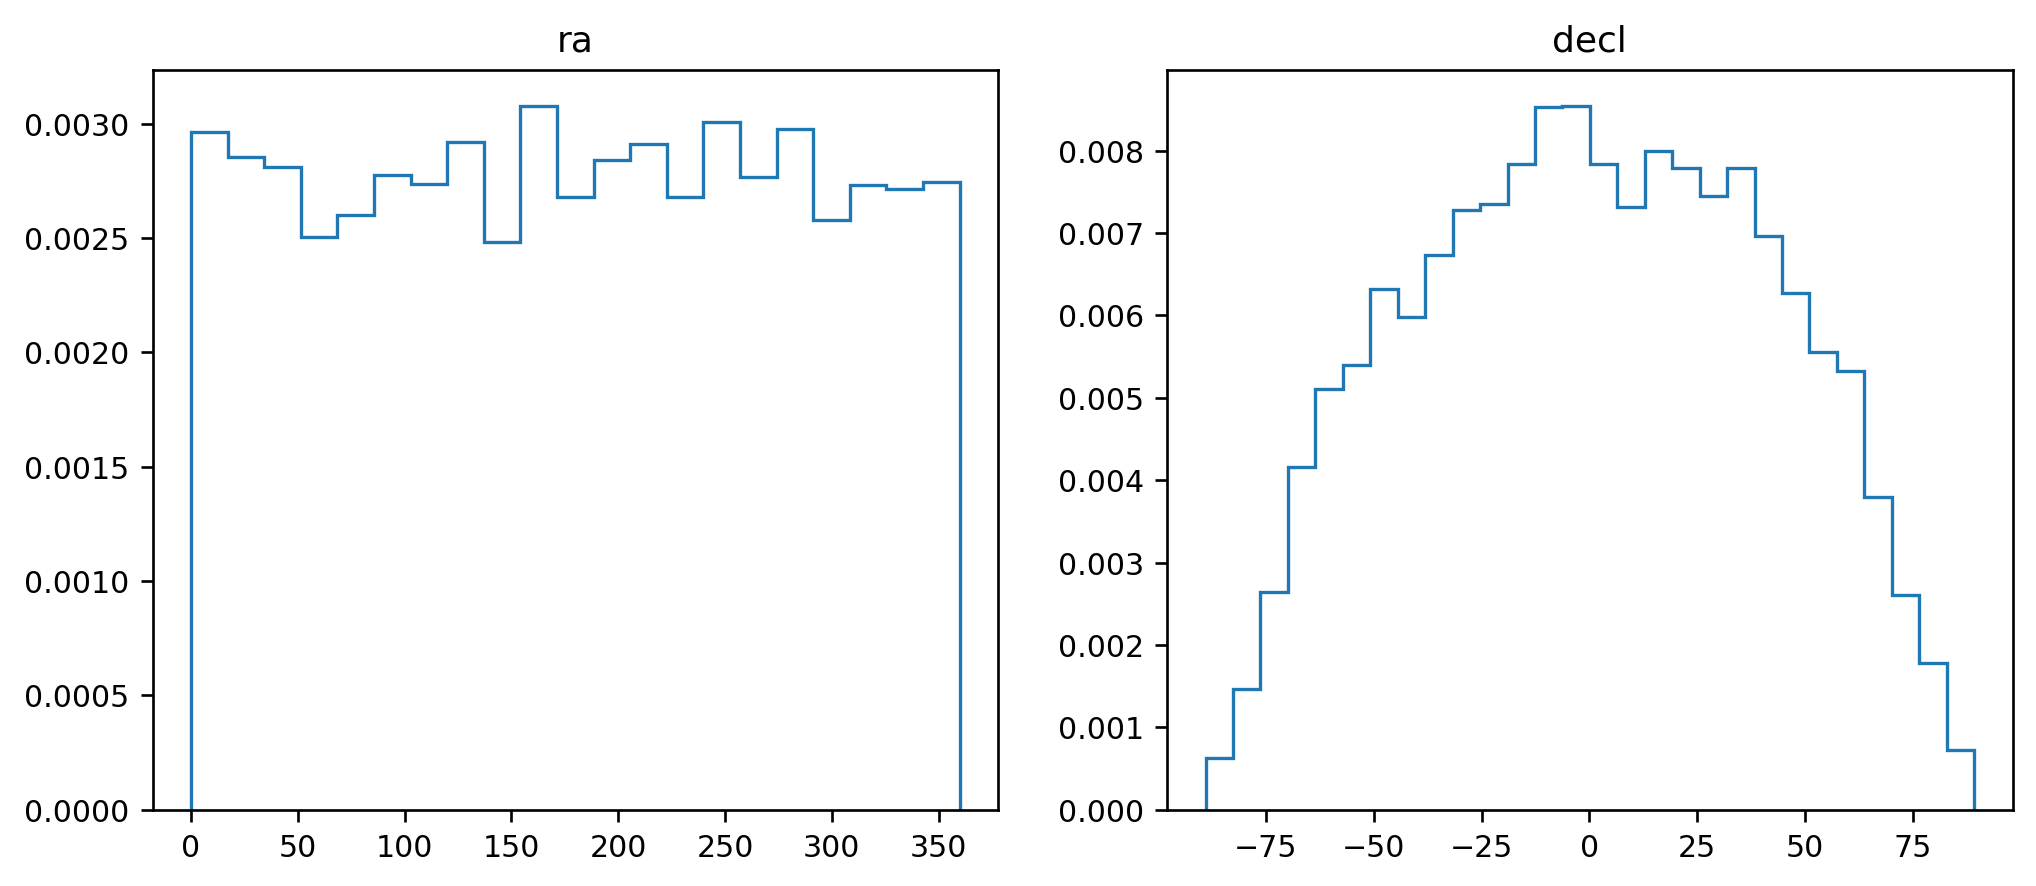

In [181]:
ra = grb['ra']
decl = grb['decl']

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig,ax = plt.subplots(1,2)
ax[0].hist(ra, histtype='step', bins='auto', density=True)
ax[0].set_title('ra')
ax[1].hist(decl, histtype='step', bins='auto', density=True)
ax[1].set_title('decl')

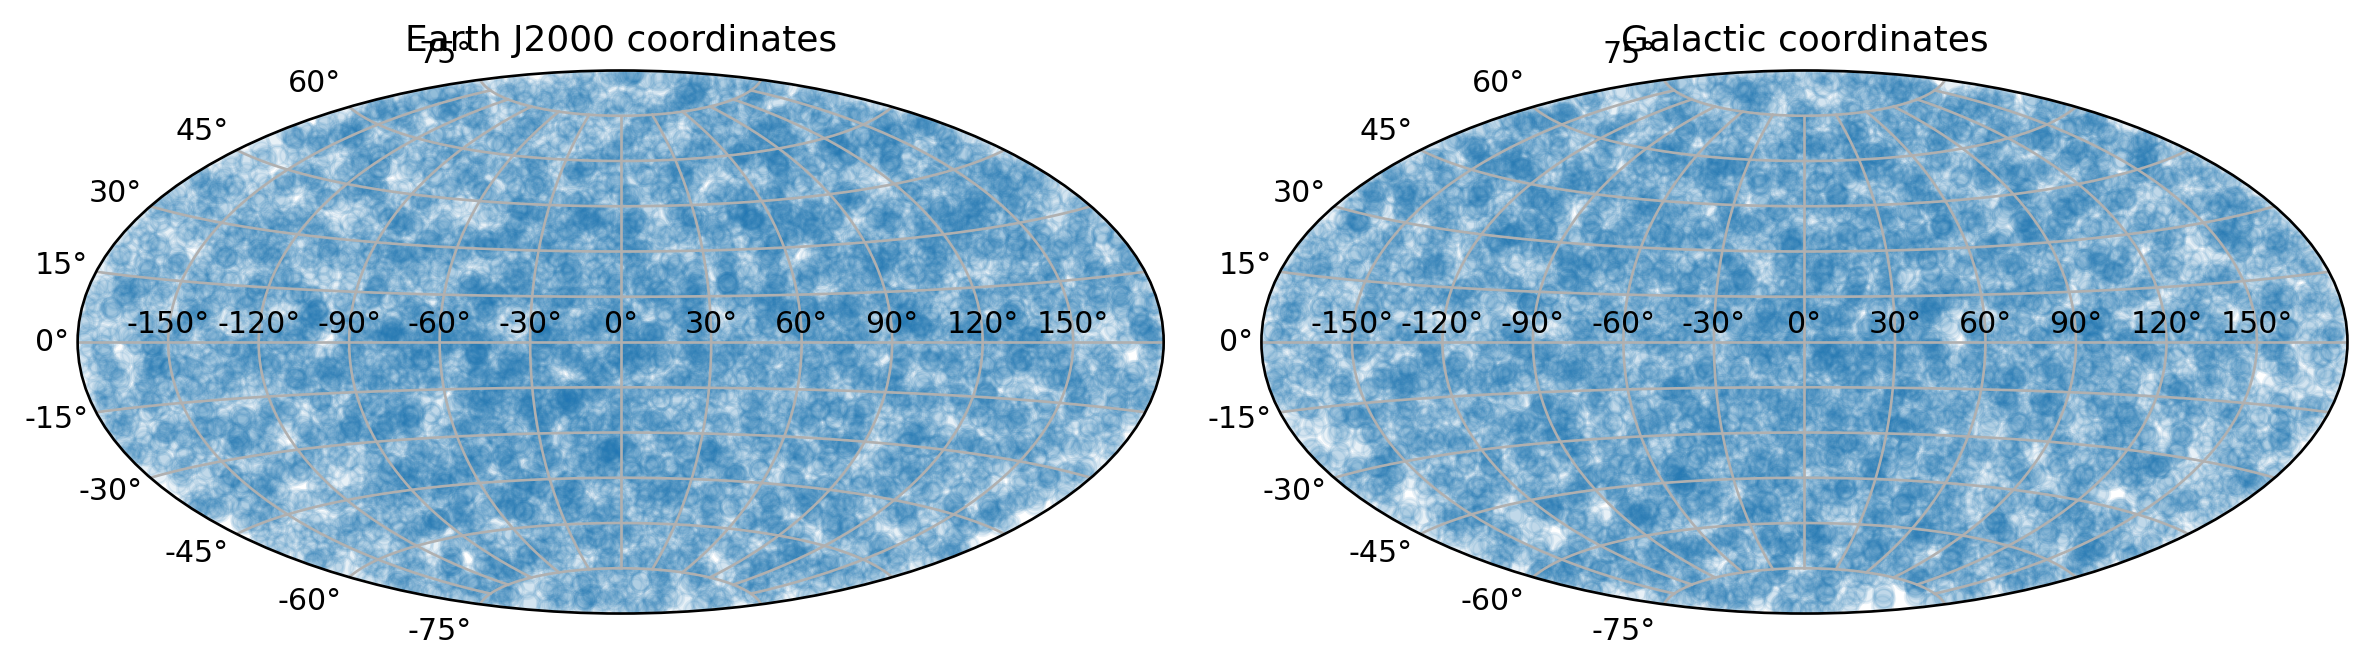

In [182]:
from astropy.coordinates import SkyCoord
import astropy.units as u

eq = SkyCoord(ra, decl, unit=u.deg)
gal = eq.galactic

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig=plt.figure()

ax1=fig.add_subplot(121,  projection='aitoff')
ax1.grid(True)
ax1.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, alpha = 0.1)
ax1.set_title('Earth J2000 coordinates')

ax2=fig.add_subplot(122,  projection='aitoff')
ax2.grid(True)
ax2.scatter(eq.ra.wrap_at('180d').radian, eq.dec.radian, alpha = 0.1)
ax2.set_title('Galactic coordinates')

plt.tight_layout()


Distribution seems uniform in the sky, no major concentration on the galactic plane

## Time and fluence
We will study log(t) and log(fluence). 

### Distributions
We start with histograms and cross-validated KDE to check distributions

#### Histograms

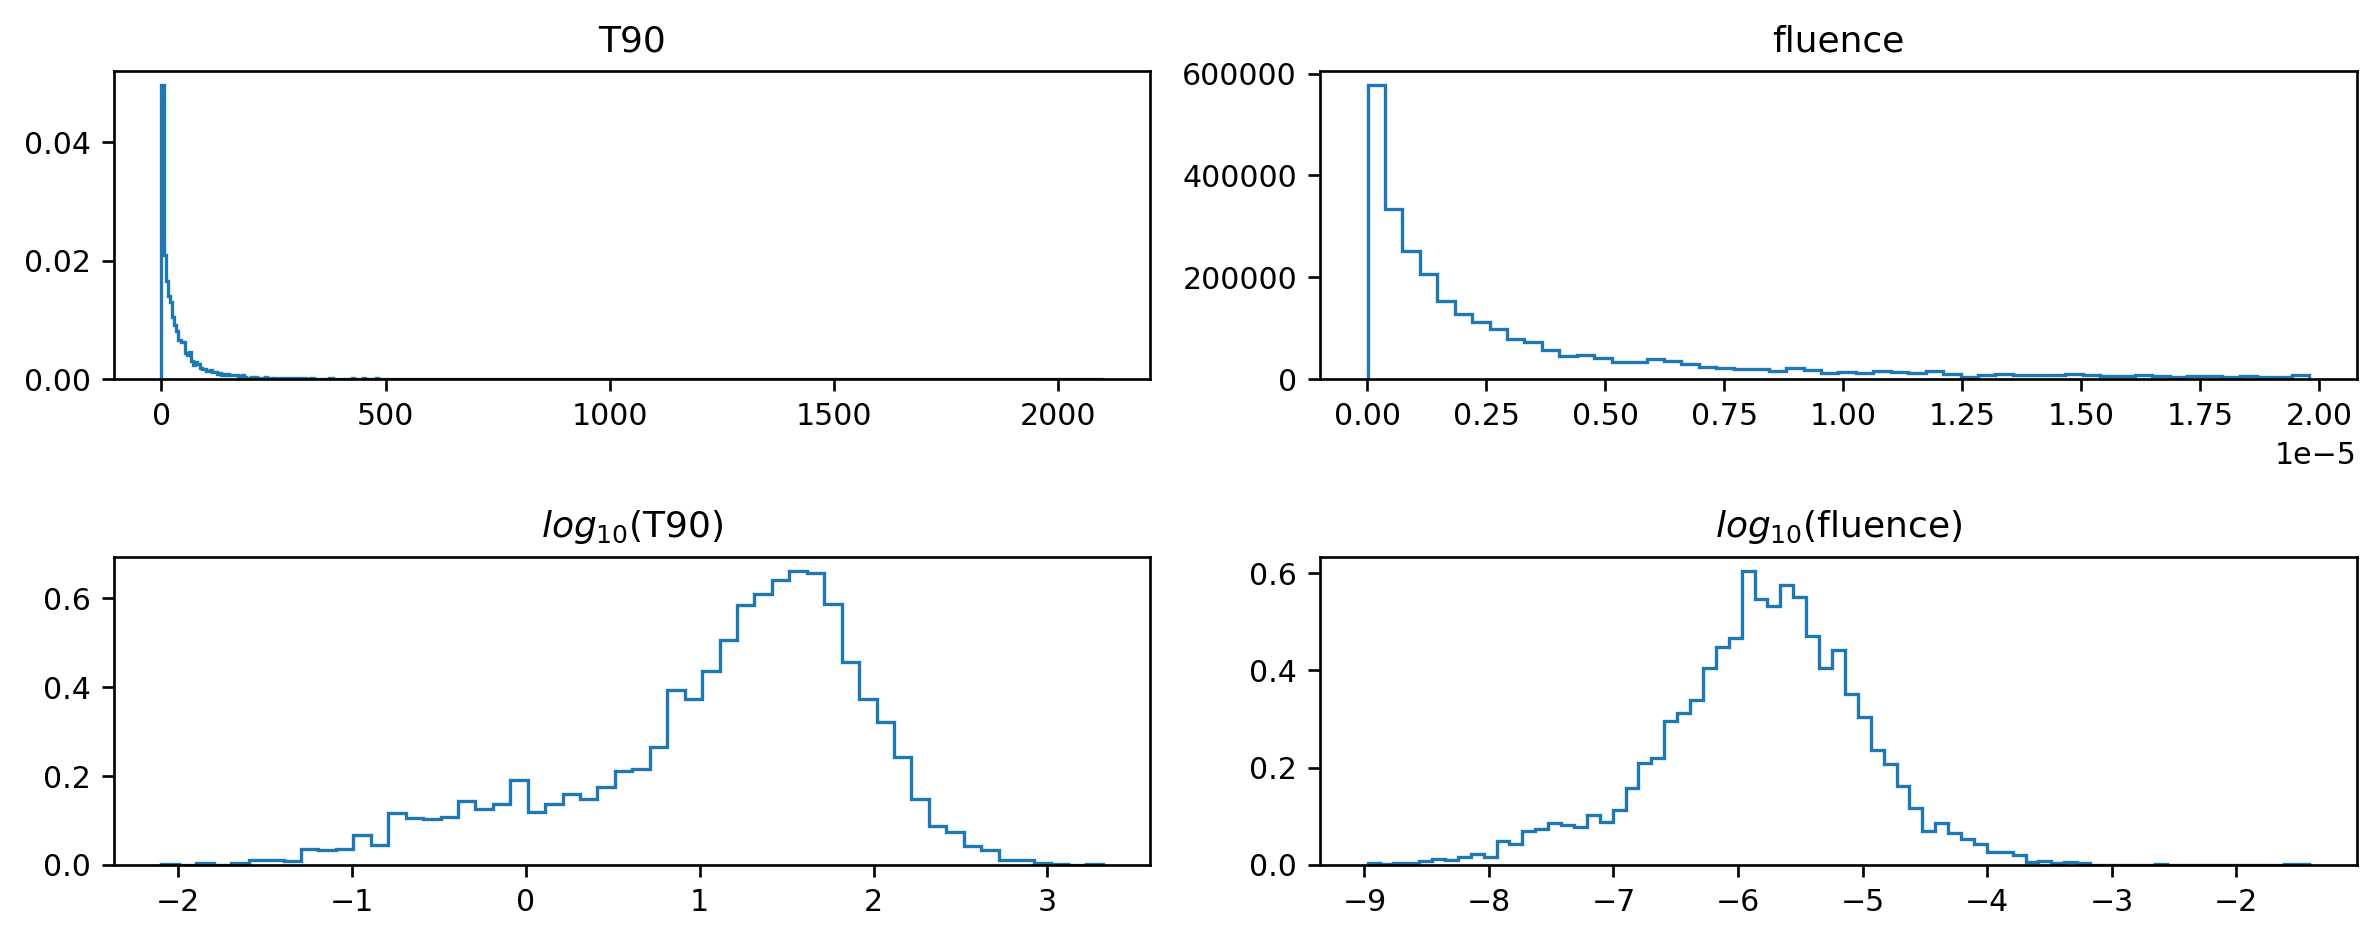

In [183]:
t = grb['T90']
fluence = grb['fluence']
mask = (t > 0) & (fluence > 0)
fluence = fluence[mask] # Remove missing data
t = t[mask]

reduced_fluence = fluence[fluence<0.00002]

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig,axs = plt.subplots(2,2)
ax = axs.flatten()

ax[0].hist(t, histtype='step', bins='auto', density=True)
ax[0].set_title(r'T90')
# ax[1].hist(fluence, histtype='step', bins='auto', density=True)
ax[1].hist(reduced_fluence, histtype='step', bins='auto', density=True)

ax[1].set_title(r'fluence')


fluence = np.log10(fluence) # Use log of quantities
t = np.log10(t)

ax[2].hist(t, histtype='step', bins='auto', density=True)
ax[2].set_title(r'$log_{10}$(T90)')
ax[3].hist(fluence, histtype='step', bins='auto', density=True)
ax[3].set_title(r'$log_{10}$(fluence)')

plt.tight_layout()

We use the log-transformed quantities, as they are much more well behaved.

#### Errors

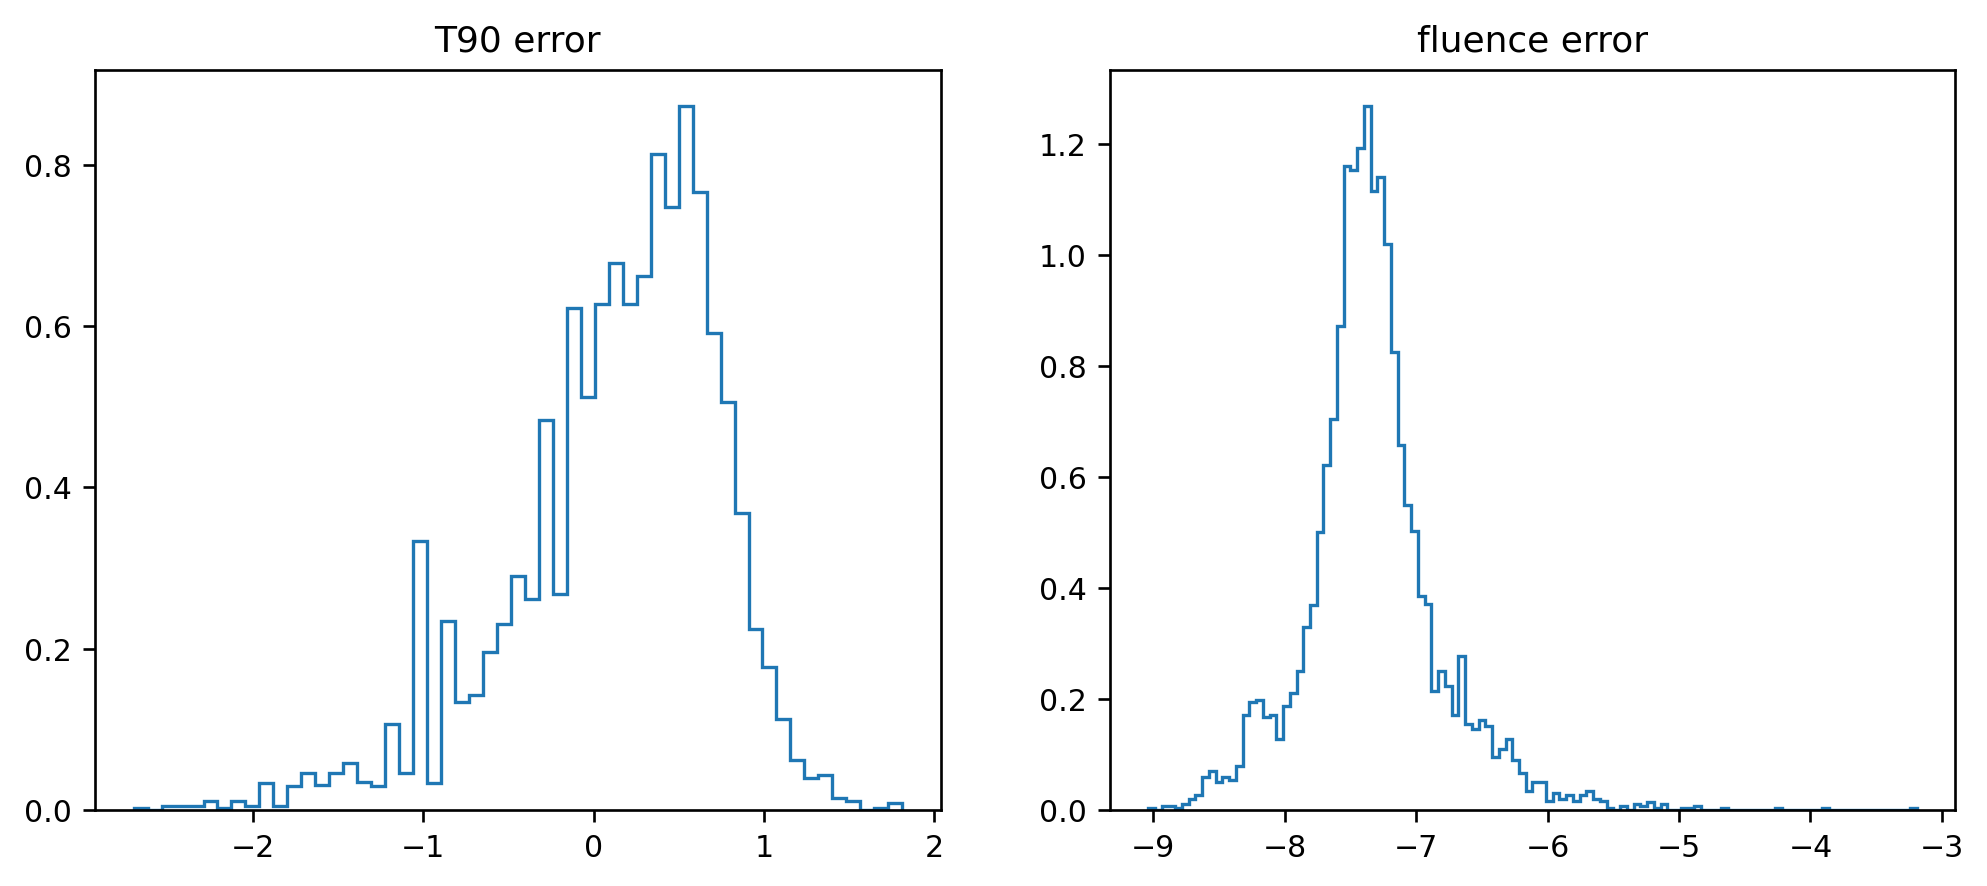

In [184]:
terr = grb['T90_error']
ferr = grb['fluence_error']

mask2 = (terr>0) & (ferr>0)

terr = terr[mask2]
ferr = ferr[mask2]

terr =np.log10(terr)
ferr=np.log10(ferr)

fig,axs = plt.subplots(1,2)

ax = axs[0]
ax.hist(terr, histtype='step', bins='auto', density=True)
ax.set_title('T90 error')

ax = axs[1]
ax.hist(ferr,  histtype='step', bins='auto', density=True)
ax.set_title('fluence error');


In [185]:
# Use only points with both values and errors:

mask3 = mask & mask2

t90_a = grb['T90'][mask3]
flu_a = grb['fluence'][mask3]

t90err_a = grb['T90_error'][mask3]
fluerr_a = grb['fluence_error'][mask3]

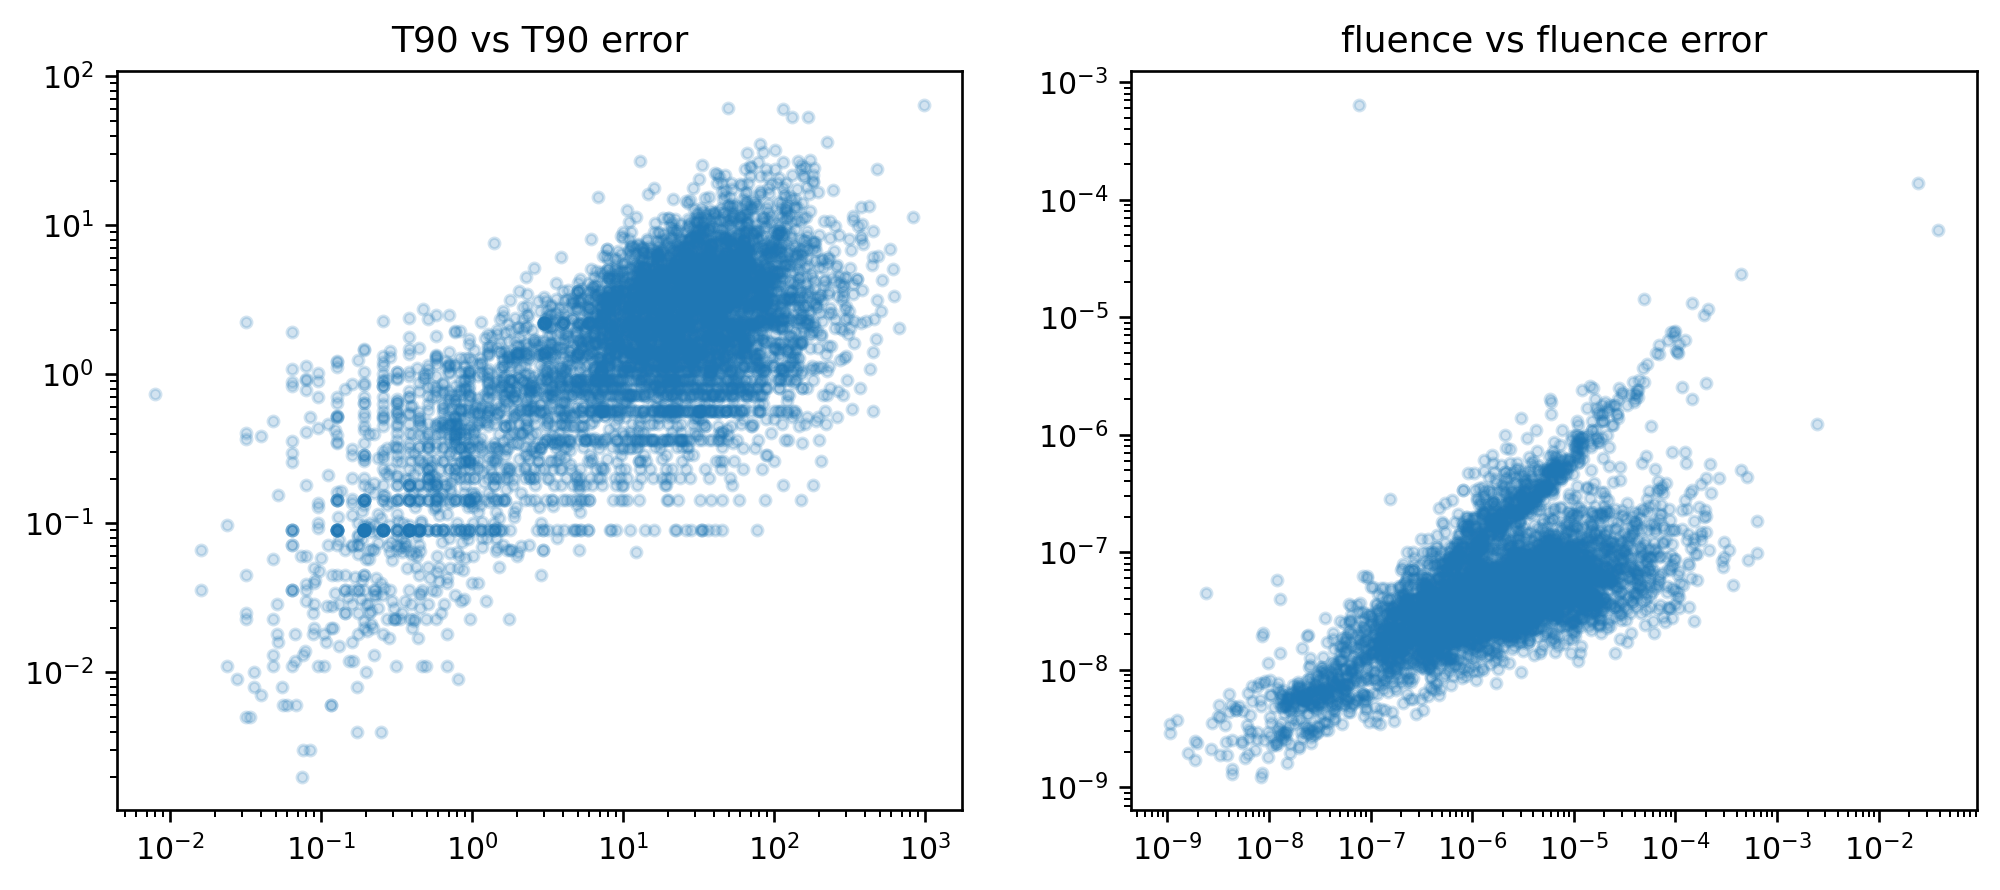

In [190]:
fig,axs = plt.subplots(1,2)

ax = axs[0]
ax.scatter(t90_a,t90err_a, alpha=0.2, s=10 )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('T90 vs T90 error')

ax = axs[1]
ax.scatter(flu_a,fluerr_a, alpha=0.2, s=10 )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('fluence vs fluence error');

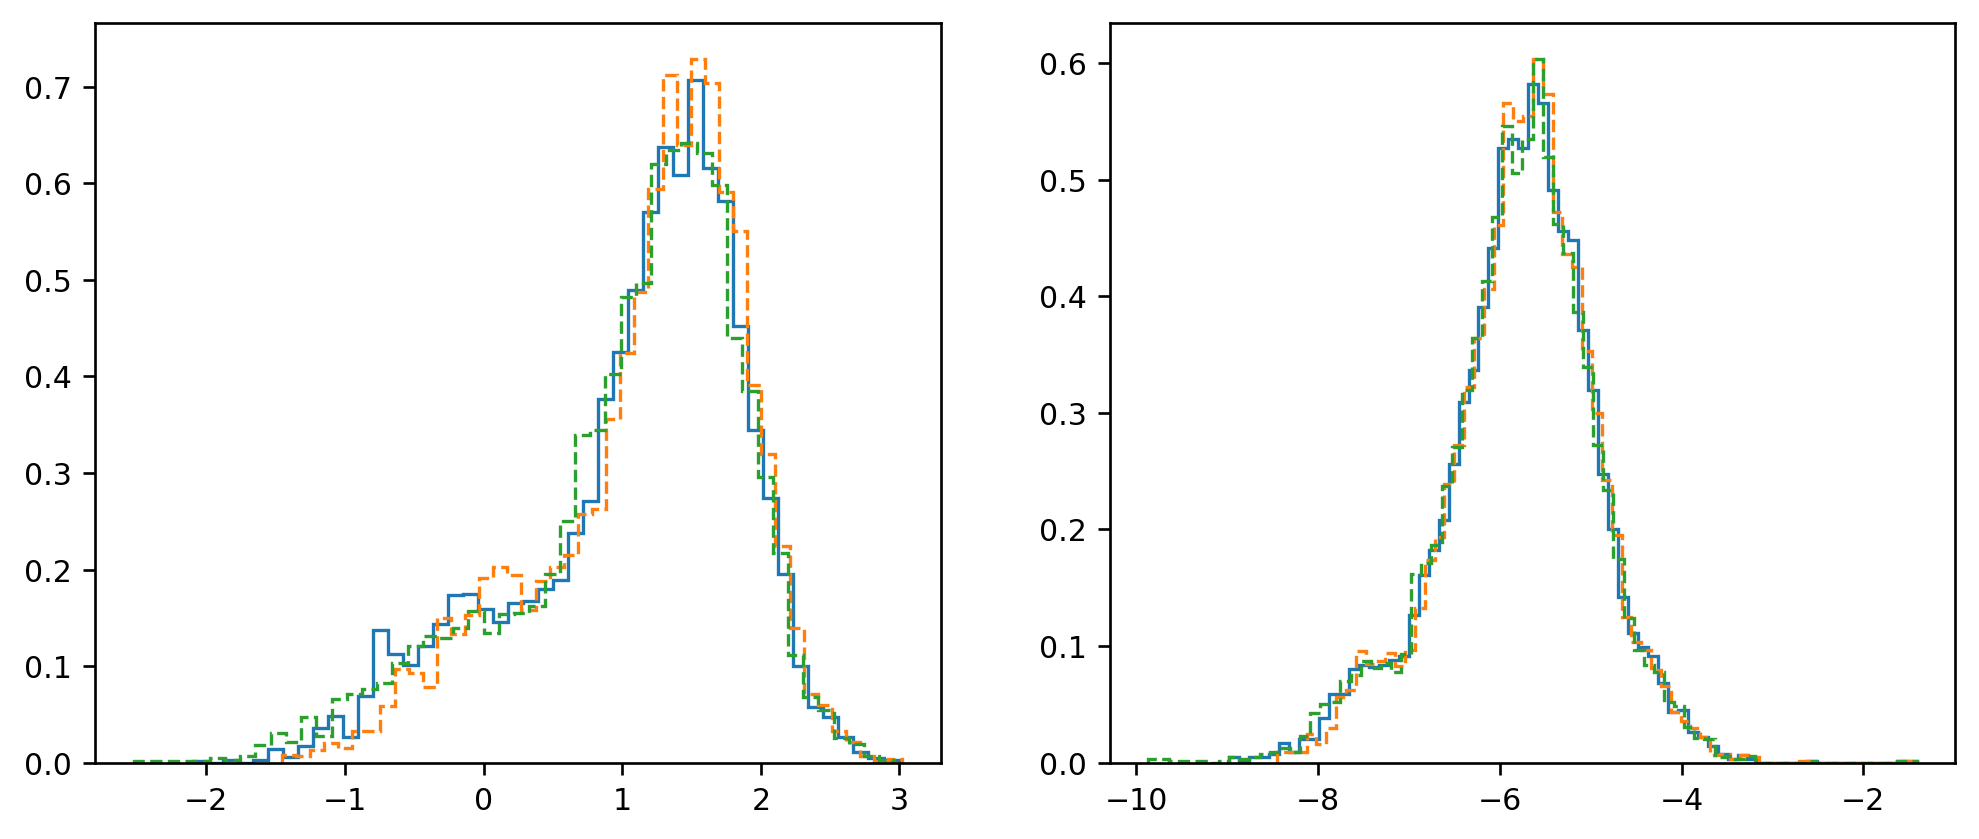

In [175]:
# Distribution broadening from error
mask4 = t90_a - t90err_a 

tlog = np.log10(t90_a)
tplus = np.log10(t90_a + t90err_a)
tminus = t90_a - t90err_a 
tminus = tminus[tminus>0]
tminus = np.log10(tminus)

flog = np.log10(flu_a)
fplus = np.log10(flu_a + fluerr_a)
fminus = flu_a - fluerr_a 
fminus = fminus[fminus>0]
fminus = np.log10(fminus)

fig,axs = plt.subplots(1,2)

ax = axs[0]
ax.hist(tlog, histtype='step', bins='auto', density=True)
ax.hist(tplus, histtype='step', bins='auto', density=True,  ls='--')
ax.hist(tminus, histtype='step', bins='auto', density=True,  ls='--')

ax = axs[1]
ax.hist(flog,  histtype='step', bins='auto', density=True);
ax.hist(fplus,  histtype='step', bins='auto', density=True, ls='--')
ax.hist(fminus,  histtype='step', bins='auto', density=True,  ls='--');




We see that even the worse case scenarios (all errors are correlated and at max value) do not change much the distributions, so we will ignore them.

#### Normalization

Normalize data using standard scaler:

In [55]:
X_2d = np.vstack((t,fluence)).T

scaler = StandardScaler()
X_2d = scaler.fit_transform(X_2d)

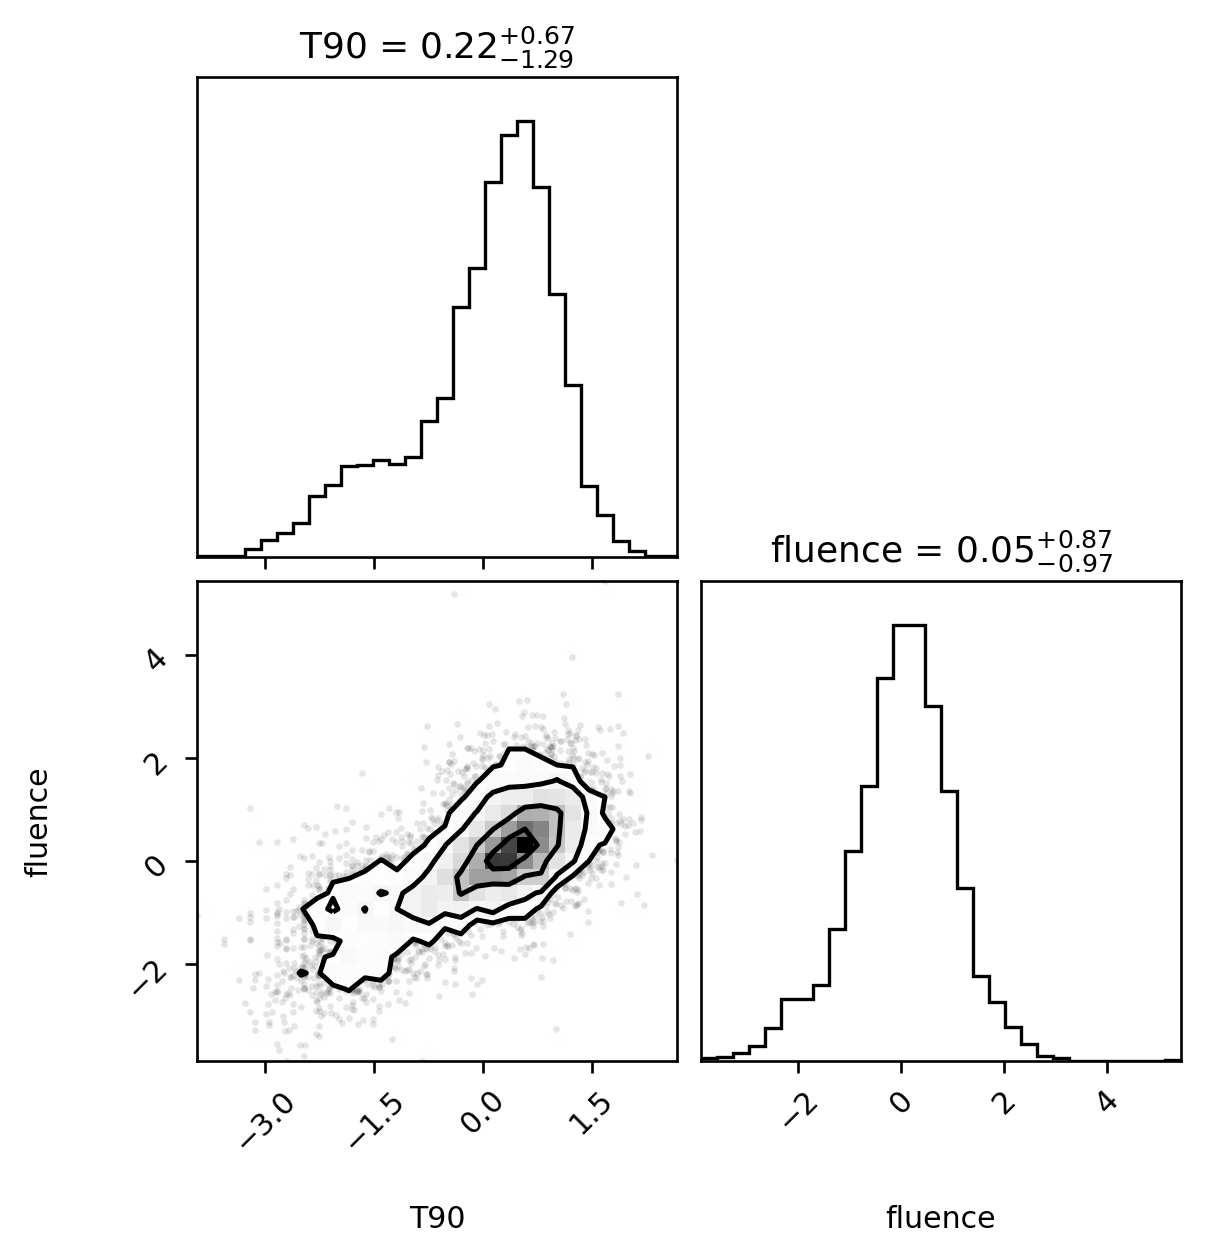

In [59]:
corner.corner(X_2d, labels=['T90','fluence'], show_titles=True, bins=30);

#### KDE

In [63]:
from astroML.utils.decorators import pickle_results
# KDE with Cross validation

X_t = X_2d[:,0][:,None]
X_f = X_2d[:,1][:,None]

K = 7

@pickle_results('double_cv.pkl')
def double_cv():
    best_bw=[]
    for X in [X_t,X_f]:
        bwrange = np.linspace(0.05, 0.5, 10)
        grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bwrange}, cv = K)
        grid.fit(X)

        best_bw.append( grid.best_params_['bandwidth'])

    return best_bw

best_bw = double_cv()

@pickle_results: using precomputed results from 'double_cv.pkl'


In [61]:
best_bw

[0.1, 0.25]

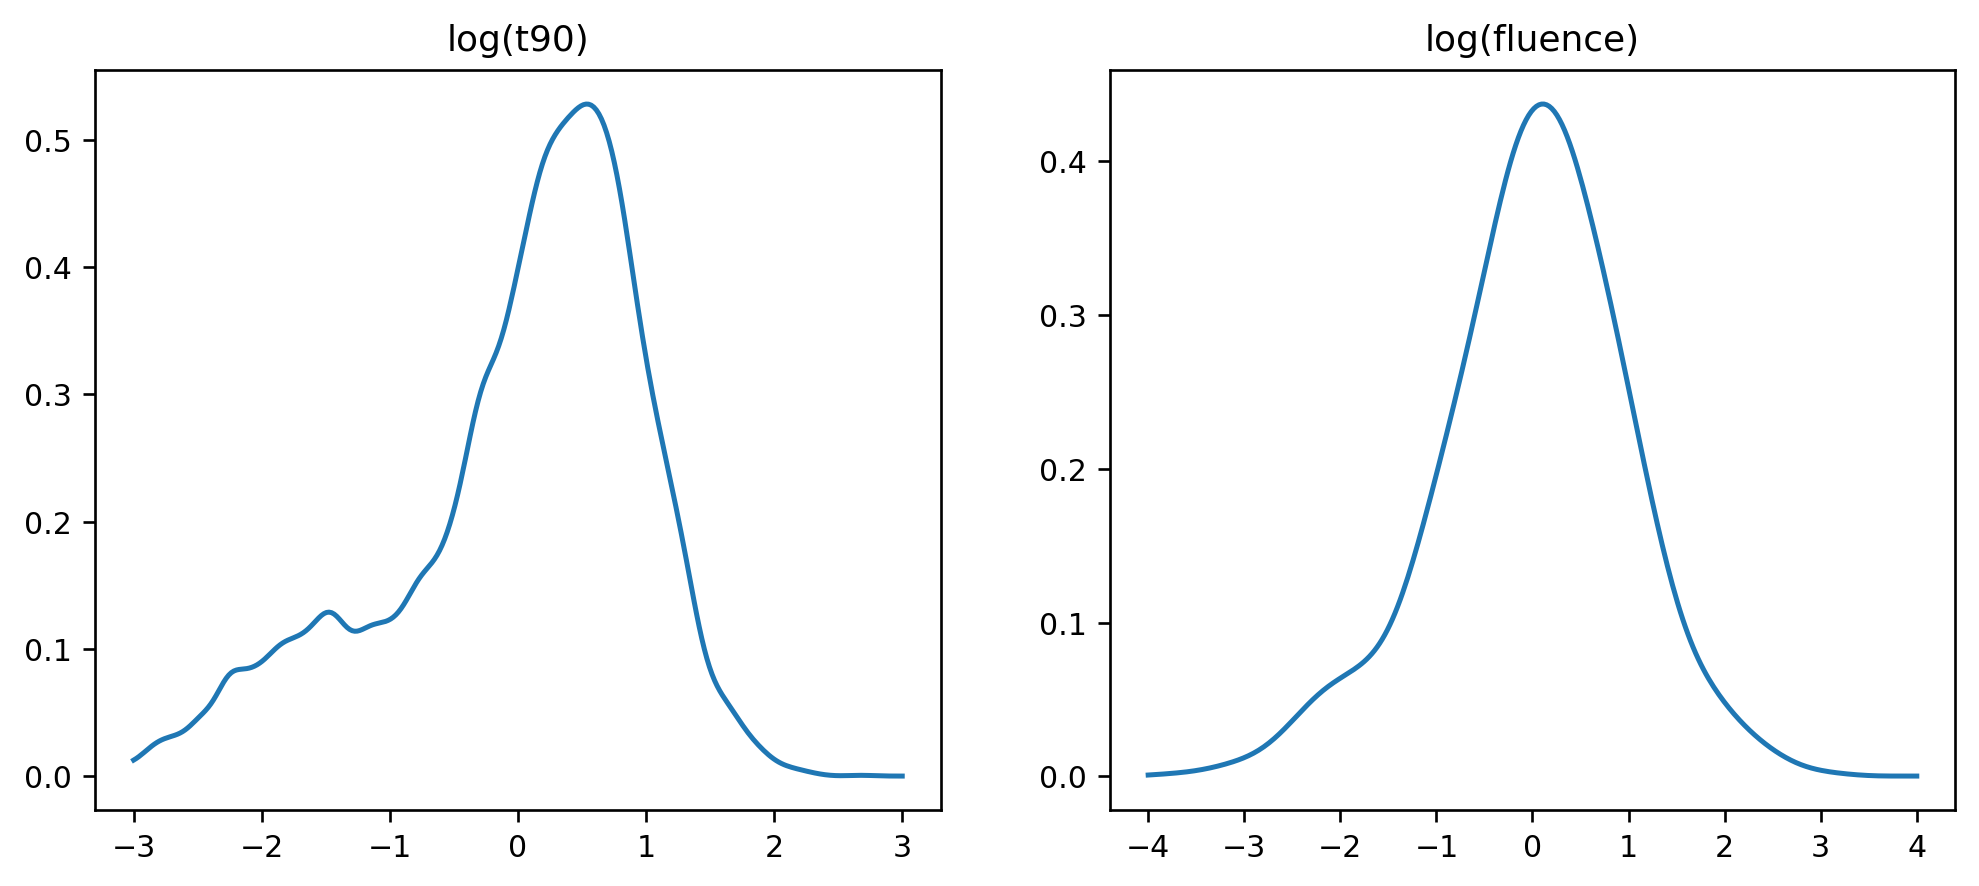

In [66]:
#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

xgrid_t=np.linspace(-3,3,300)
xgrid_f=np.linspace(-4,4,300)

fig, axes = plt.subplots(1,2)
titles = ['log(t90)', 'log(fluence)']

for ax, X, xgrid, bw,title in zip(axes, [X_t,X_f], [xgrid_t, xgrid_f], best_bw,titles):
    kde = KernelDensity(bandwidth = bw, kernel='gaussian')
    kde.fit(X)
    ygrid = np.exp(kde.score_samples(xgrid[:,np.newaxis]))
    ax.plot(xgrid, ygrid)
    ax.set_title(title);


We can see slight bimodality in t90, just a little bump in fluence.  We will start with exploring the time feature.

## Clustering


### Gaussian Mixture

In [102]:
from sklearn.mixture import GaussianMixture
X=X_2d[:,0]
X = X[:, None]
mix = GaussianMixture(2)
mix.fit(X)

GaussianMixture(n_components=2)

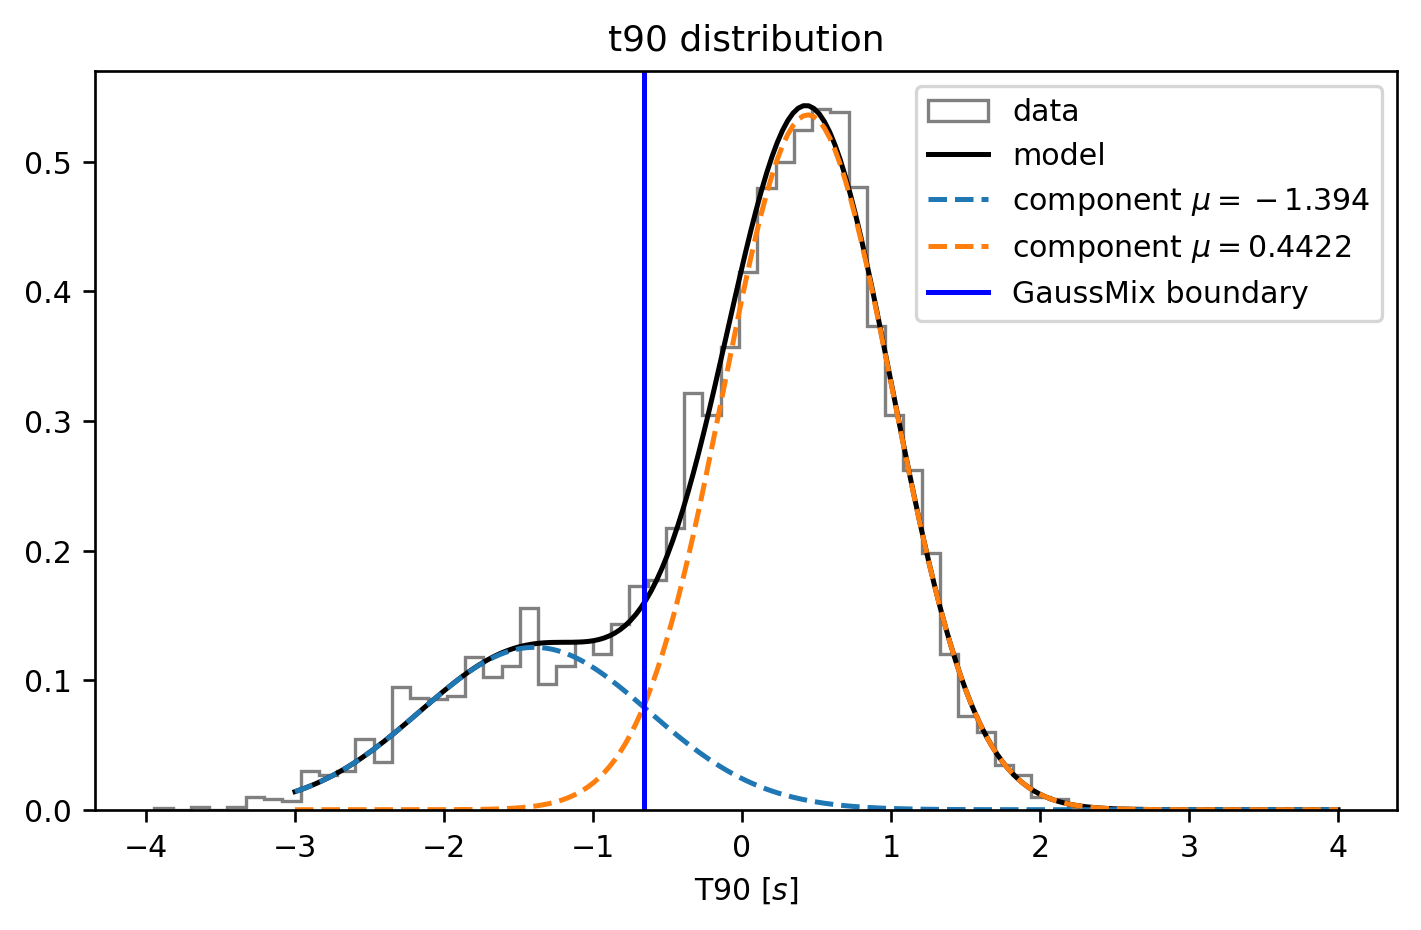

In [104]:
from scipy.stats import norm
mix_best = mix

x_grid = np.linspace(-3,4,200)
logl = mix_best.score_samples(x_grid[:,np.newaxis])
prob = np.exp(logl)

means = mix_best.means_
weights = mix_best.weights_
sigmas = np.sqrt(mix_best.covariances_)

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(7, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

plt.hist(X, bins='auto', density=True, histtype='step', color='grey', label='data')
plt.plot(x_grid,prob, c='k', label='model')

for a, mu, sigma in zip(weights,means[:,0],sigmas[:,0,0]):
    dist = norm(loc=mu, scale=sigma).pdf
    plt.plot(x_grid, a*dist(x_grid), ls='--', label=f'component $\mu = {mu:.4}$')


plt.title('t90 distribution')
plt.xlabel(r'T90 [$s$]')

labels_gm = mix.predict(X)
decision_ms = np.mean( [max(X[labels_gm==0]), min(X[labels_gm==1]) ])
plt.axvline(decision_ms, c='blue', label = 'GaussMix boundary')
plt.legend()


Quite nice, we can recognize 2 different populations. Since this is in log, the duration of the lower population is about 1-1,5 orders of magnitude lower, could be from different physics phenomena.

#### Mean Shift and K-Means

In [52]:
from sklearn.cluster import MeanShift
from sklearn.cluster import KMeans

# Mean SHift
ms = MeanShift(n_jobs=-1, bandwidth=0.5) #Setting by hand RBF kernel bandwith to compute the weighted mean for centroids
ms.fit(X)
centers_ms = ms.cluster_centers_.T[0]
print(f'MeanShift centroids: {centers_ms}')

labels_ms = ms.predict(X)
decision_ms = np.mean( [max(X[labels_ms==0]), min(X[labels_ms==1]) ])


# K Means
kmean = KMeans(n_clusters=2)
kmean.fit(X)
centers_km = kmean.cluster_centers_.T[0]
print(f'K-Means centroids: {centers_km}')

labels_km = kmean.predict(X)
decision_km = np.mean( [max(X[labels_km==0]), min(X[labels_km==1]) ])

MeanShift centroids: [ 0.45726902 -1.40144683]
K-Means centroids: [-1.41673218  0.48630387]


Meanshift was able to recognize two clusters only after manually setting the bandwidth for the kernel (which dictates the region to search though)

Text(0.5, 0, '$\\log_{10}$T90 [$s$]')

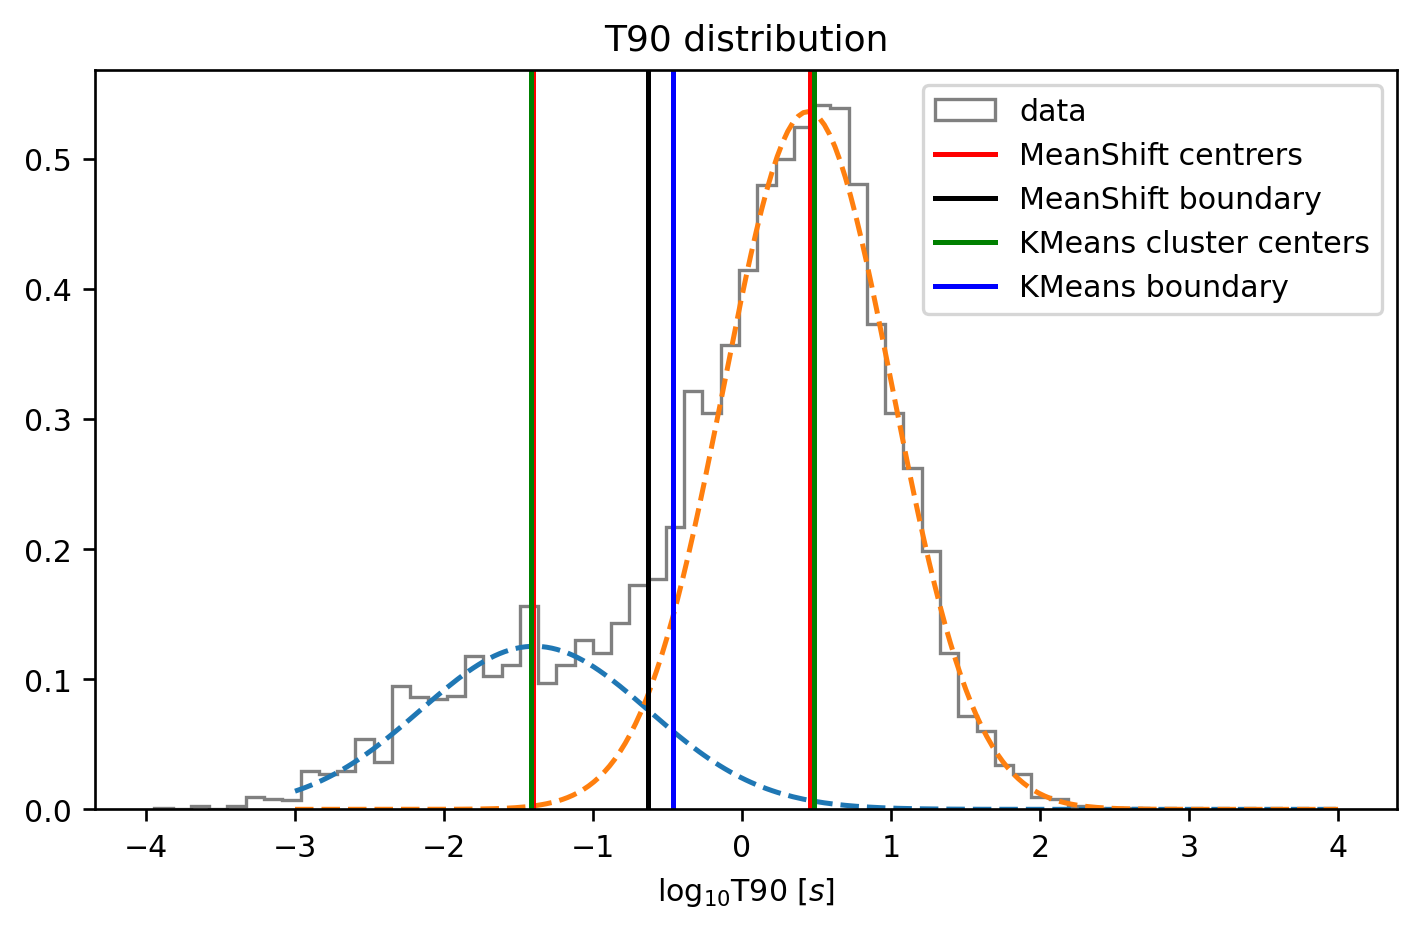

In [53]:
#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(7, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

plt.hist(X, bins='auto', density=True, histtype='step', color='grey', label='data')
# plt.plot(x_grid,prob, c='k', label='model')

for a, mu, sigma in zip(weights,means[:,0],sigmas[:,0,0]):
    dist = norm(loc=mu, scale=sigma).pdf
    plt.plot(x_grid, a*dist(x_grid), ls='--')

plt.axvline(centers_ms[0], c='red' , label='MeanShift centrers')
plt.axvline(centers_ms[1], c='red')
plt.axvline(decision_ms, c='k', label = 'MeanShift boundary')



plt.axvline(centers_km[0], c='green' , label='KMeans cluster centers')
plt.axvline(centers_km[1], c='green')
plt.axvline(decision_km, c='blue', label = 'KMeans boundary')


plt.legend()
plt.title('T90 distribution')
plt.xlabel(r'$\log_{10}$T90 [$s$]')

Quite similar reults. In particular, MeanShift boundary is almost the same as the one from Gaussian Mixture

Let's try to run them on the 2D t90 - fluence subspace, and compare the two class divions.


In [108]:
mix2d = GaussianMixture(2)
mix2d.fit(X_2d)

means = mix2d.means_
weights = mix2d.weights_
covs = mix2d.covariances_

print(means)

[[ 0.45769133  0.35999664]
 [-1.31703252 -1.03591057]]


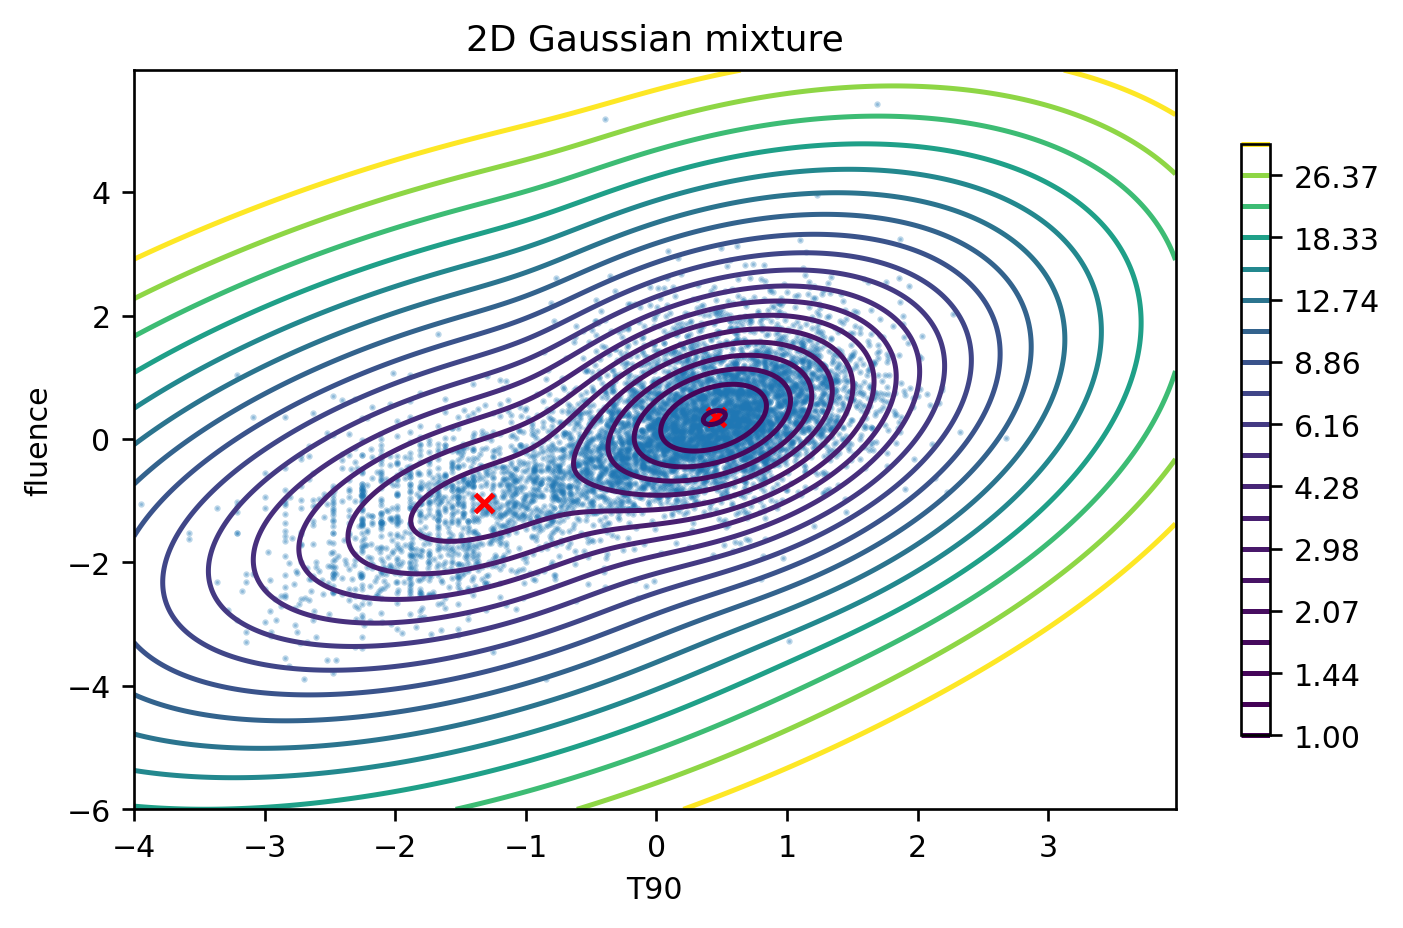

In [121]:
from matplotlib.colors import LogNorm
delta = 0.025
x = np.arange(-4.0, 4.0, delta)
y = np.arange(-6.0, 6.0, delta)
xx, yy = np.meshgrid(x, y)
XX = np.array([xx.ravel(), yy.ravel()]).T
    
Z = -mix2d.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, levels=np.logspace(0, 1.5, 20))
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(X_2d[:, 0], X_2d[:, 1], 0.8, alpha=0.3)
plt.title('2D Gaussian mixture')
plt.xlabel('T90')
plt.ylabel('fluence')
plt.scatter(means[:,0], means[:,1], 30, marker='x', color='r')

In [133]:
# GaussianMixture
gm = GaussianMixture(2)
gm.fit(X_2d)
gm_centers_2d = gm.means_ 
gm_labels_2d = gm.predict(X_2d)
print(gm_centers_2d)

# KMeans
km = KMeans(n_clusters = 2)
km.fit(X_2d)
km_centers_2d = km.cluster_centers_ 
km_labels_2d = km.predict(X_2d)
print(km_centers_2d)


[[-1.31703252 -1.03591057]
 [ 0.45769133  0.35999664]]
[[ 0.49151128  0.43028712]
 [-1.29141168 -1.13054945]]


In [130]:
#MeanShift
ms = MeanShift(n_jobs=-1, bandwidth=1)
ms.fit(X_2d)
ms_centers_2d = ms.cluster_centers_ 
ms_labels_2d = ms.predict(X_2d)
print(ms_centers_2d)

[[ 0.42076295  0.23869376]
 [ 1.68854757  5.42606917]
 [ 1.01477599 -3.27327732]
 [-0.39676694  5.18205813]]


It seems that meanshift is not ableto perform a sensible clustering (too many centroids)

Text(0.5, 1.0, '1D Gaussian Mixture clustering on t90 feature')

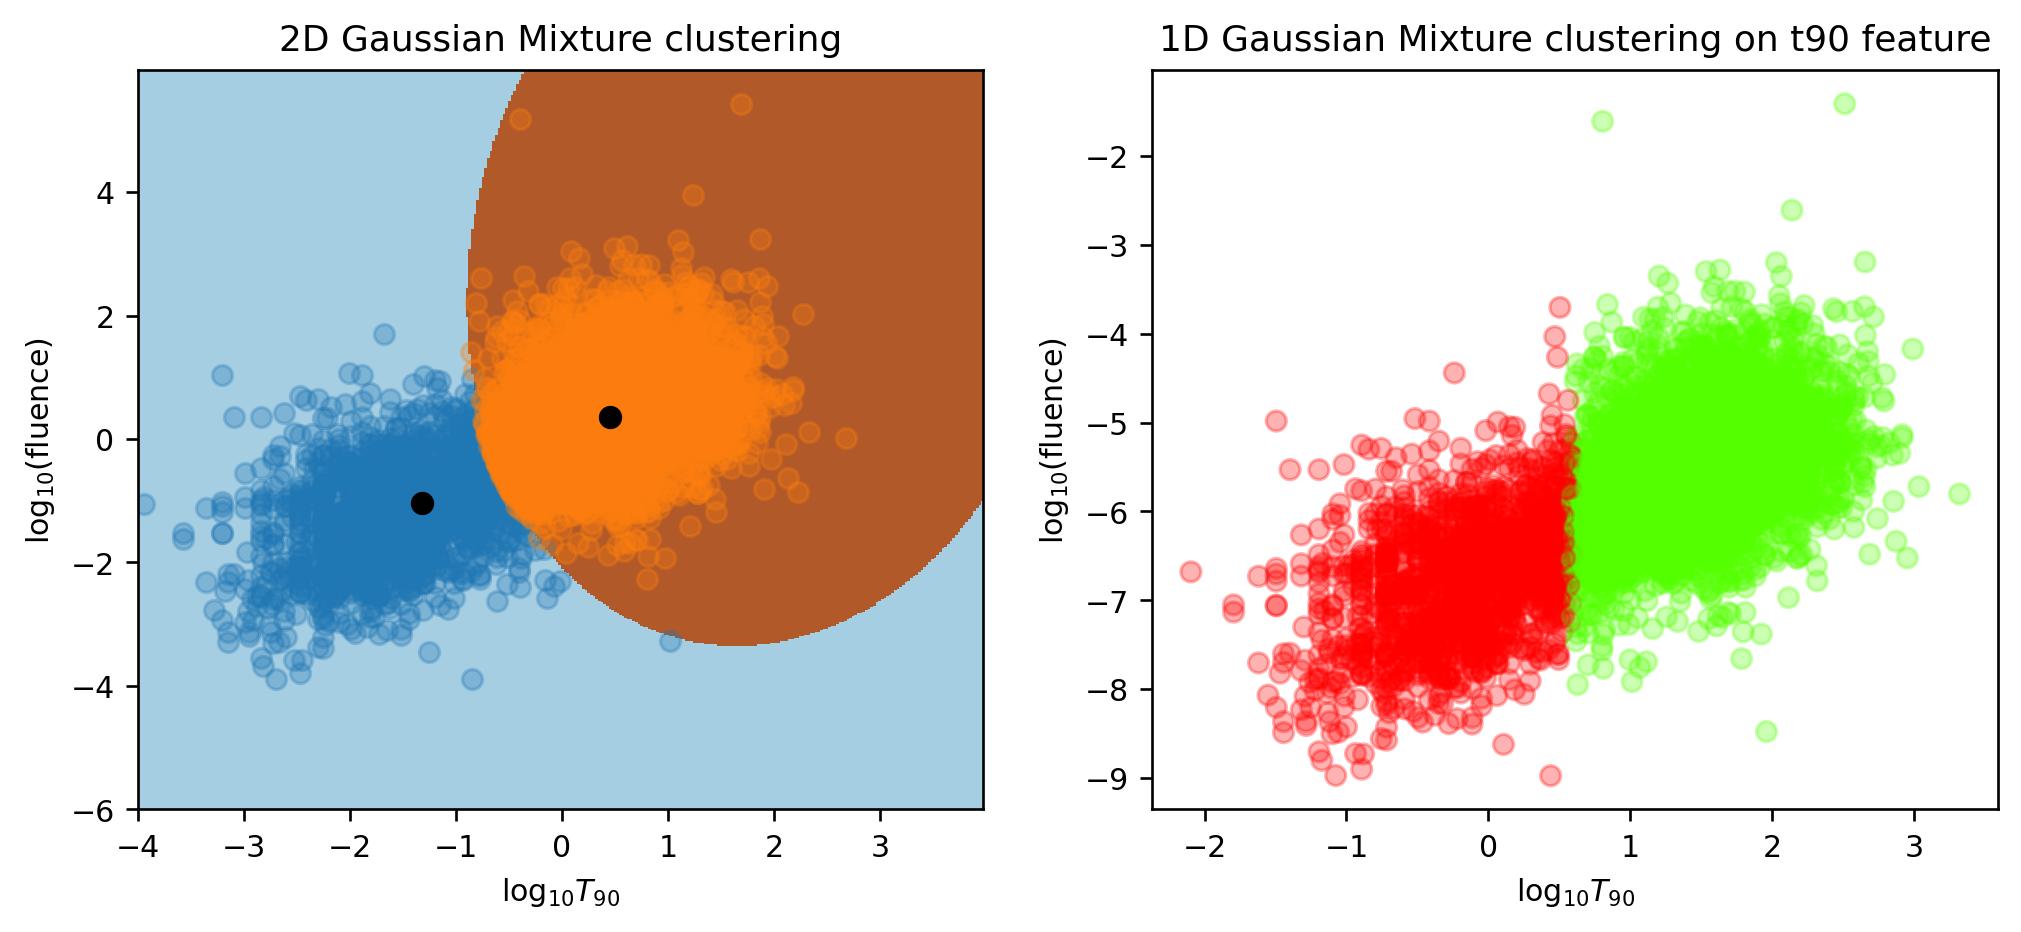

In [141]:
#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

ax = plt.subplot(121)
for i in range(2):
    ax.scatter(X_2d[gm_labels_2d == i, 0], X_2d[gm_labels_2d == i, 1], alpha = 0.3)
ax.scatter(gm_centers_2d[:, 0], gm_centers_2d[:, 1], c='k')

# Decision boundaries
delta = 0.025
x = np.arange(-4.0, 4.0, delta)
y = np.arange(-6.0, 6.0, delta)
xx, yy = np.meshgrid(x, y)
XX = np.array([xx.ravel(), yy.ravel()]).T
Z = gm.predict(XX)
Z = Z.reshape(xx.shape)
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

ax.set_xlabel(r'$\log_{10}T_{90}$')
ax.set_ylabel(r'$\log_{10}$(fluence)')
ax.set_title('2D Gaussian Mixture clustering')

ax = plt.subplot(122)
ax.scatter(t,fluence, c=labels_gm, cmap='prism' , edgecolors=None, alpha=0.3)
ax.set_xlabel(r'$\log_{10}T_{90}$')
ax.set_ylabel(r'$\log_{10}$(fluence)')
ax.set_title('1D Gaussian Mixture clustering on t90 feature')


Text(0.5, 1.0, '1D K-Means clustering on t90 feature')

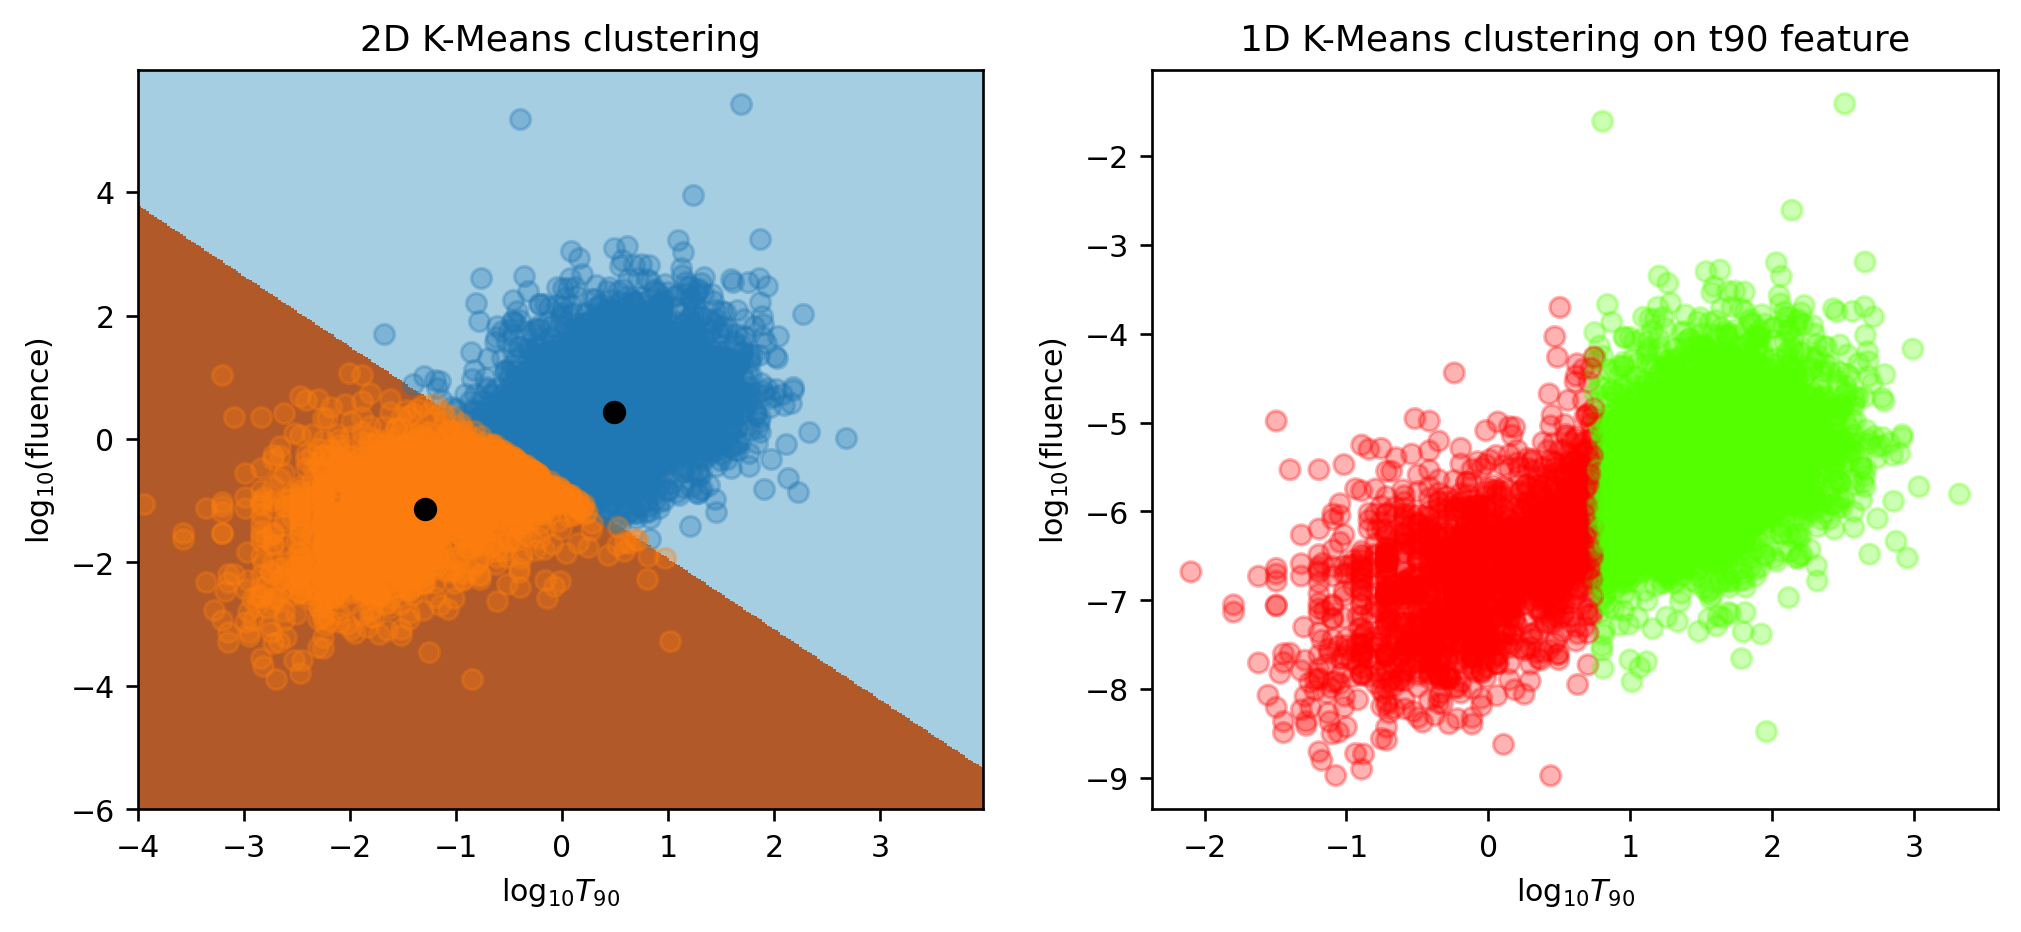

In [140]:
ax = plt.subplot(121)
for i in range(2):
    ax.scatter(X_2d[km_labels_2d == i, 0], X_2d[km_labels_2d == i, 1], alpha = 0.3)
ax.scatter(km_centers_2d[:, 0], km_centers_2d[:, 1], c='k')

ax.set_xlabel(r'$\log_{10}T_{90}$')
ax.set_ylabel(r'$\log_{10}$(fluence)')
ax.set_title('2D K-Means clustering')

# Decision boundaries
delta = 0.025
x = np.arange(-4.0, 4.0, delta)
y = np.arange(-6.0, 6.0, delta)
xx, yy = np.meshgrid(x, y)
XX = np.array([xx.ravel(), yy.ravel()]).T
Z = km.predict(XX)
Z = Z.reshape(xx.shape)
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

ax = plt.subplot(122)
ax.scatter(t,fluence, c=labels_km, cmap='prism' , edgecolors=None, alpha=0.3)
ax.set_xlabel(r'$\log_{10}T_{90}$')
ax.set_ylabel(r'$\log_{10}$(fluence)')
ax.set_title('1D K-Means clustering on t90 feature')

## PCA


Try PCA in 'T90', 'T90_error', 'fluence', 'fluence_error' 

In [201]:
t = grb['T90']
terr = grb['T90_error']
f = grb['fluence']
ferr = grb['fluence_error']

mask = (t>0) & (terr>0) & (f>0) & (ferr>0) 

t = np.log10(t[mask])
terr = np.log10(terr[mask])
f = np.log10(f[mask])
ferr = np.log10(ferr[mask])

Xpca = np.vstack((t,terr,f,ferr)).T

In [202]:
scale = StandardScaler()
scale.fit_transform(Xpca);

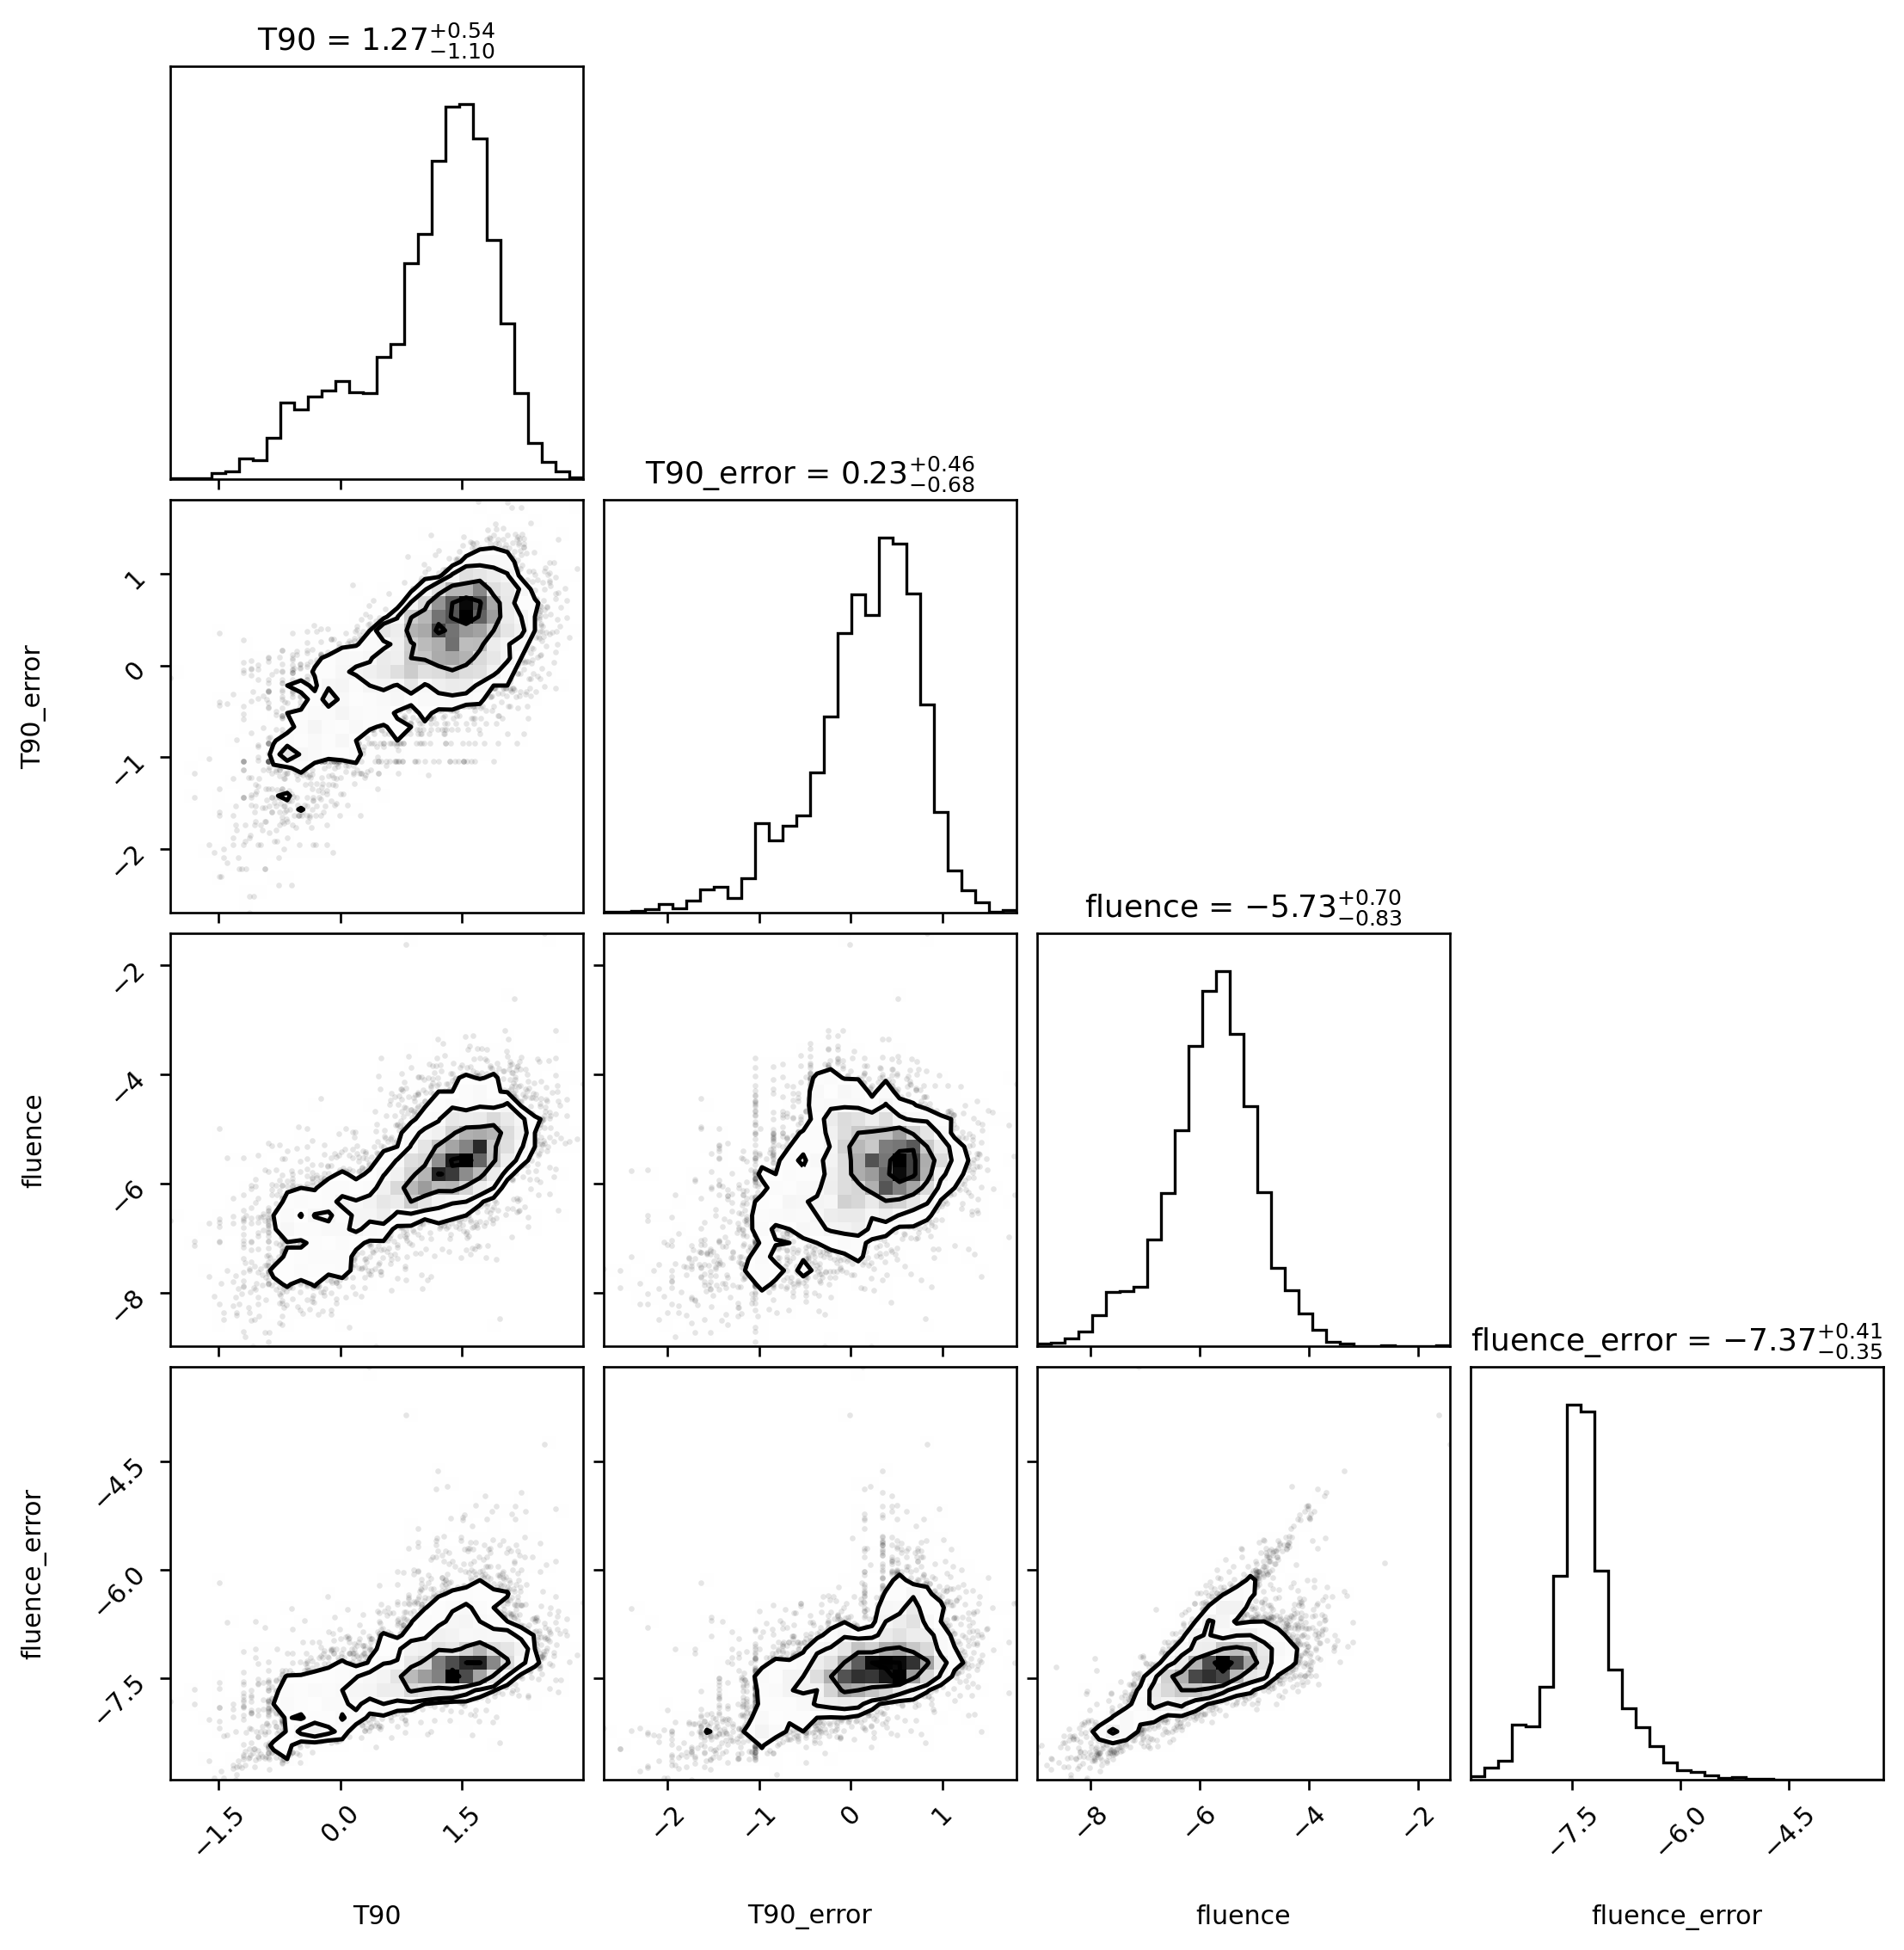

In [203]:
corner.corner(Xpca, labels=['T90', 'T90_error', 'fluence', 'fluence_error'], show_titles=True, bins=30);

[0.72468432 0.16562063 0.0741517  0.03554335]


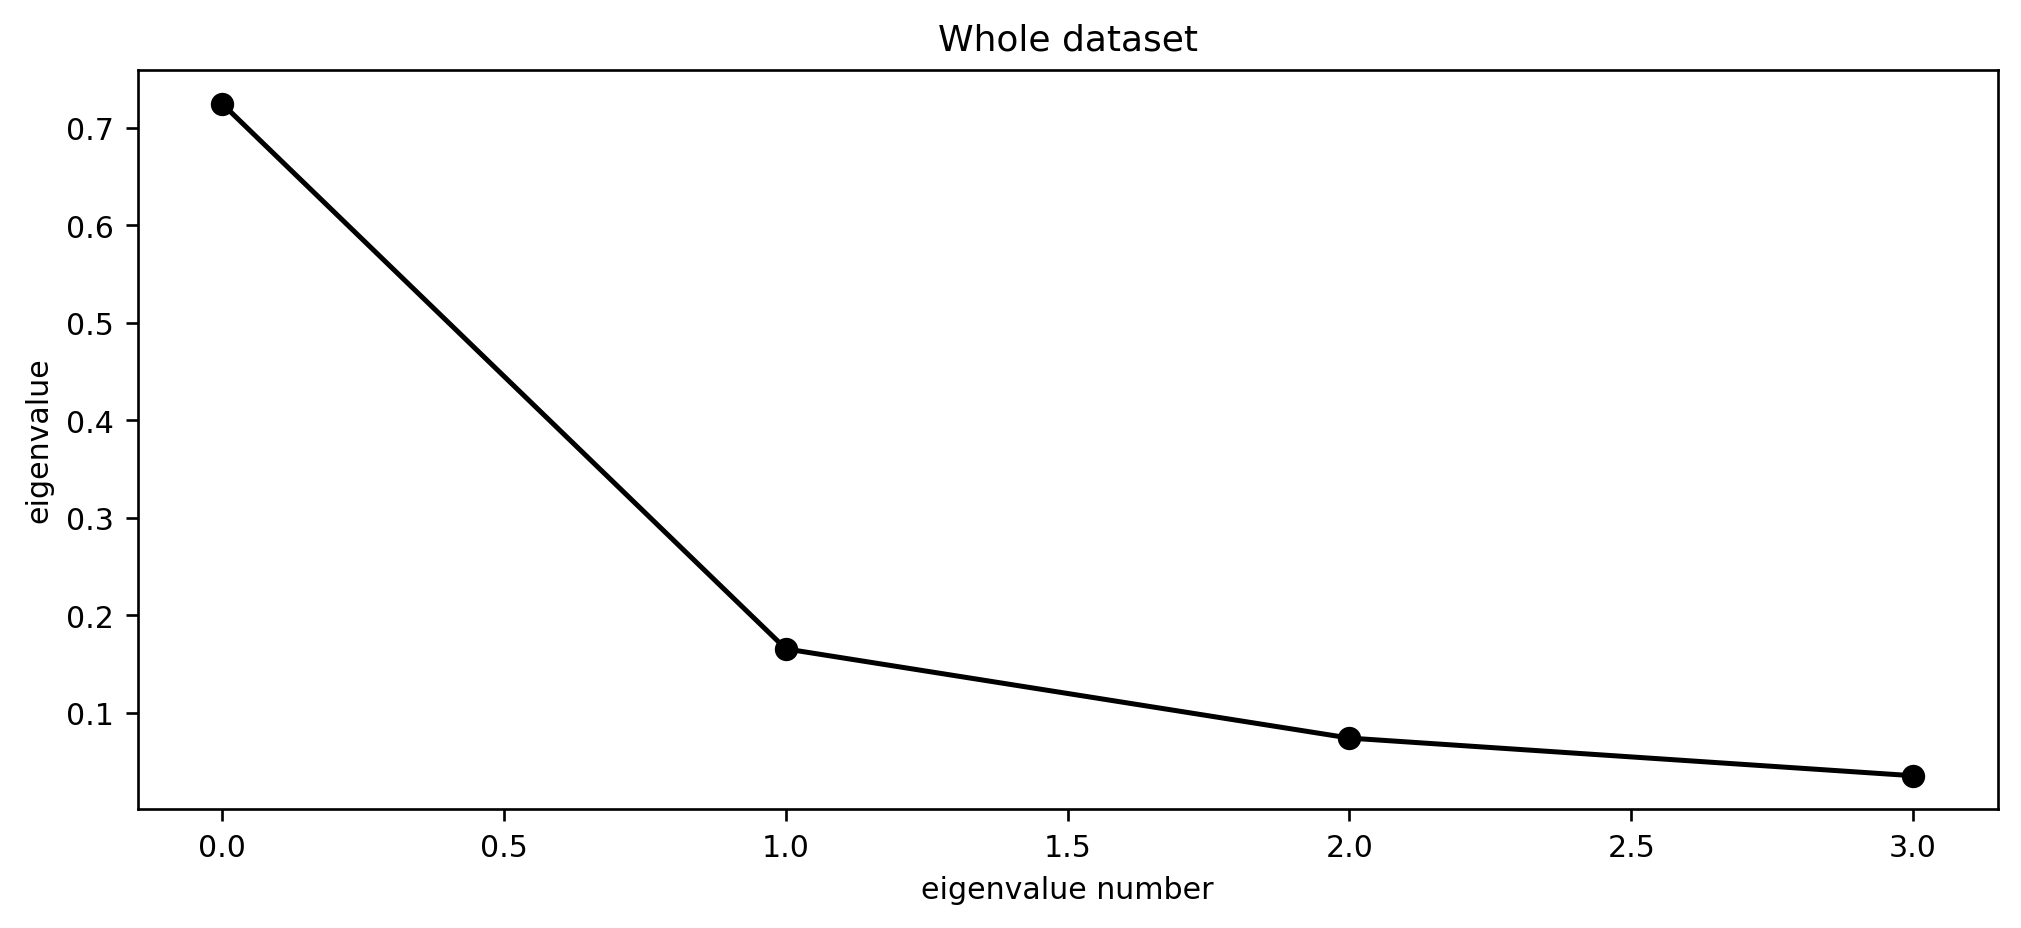

In [208]:
n_components = 4
pca = PCA(n_components=n_components)

pca.fit(Xpca)
evals = pca.explained_variance_ratio_ 
plt.plot(np.arange(n_components), evals, '-ok')
plt.xlabel('eigenvalue number')
plt.ylabel('eigenvalue')
plt.title('Whole dataset')
print(evals)

Let's try and use the first 2 PCA eigenvectors

Text(0, 0.5, 'Eigenvalue 2')

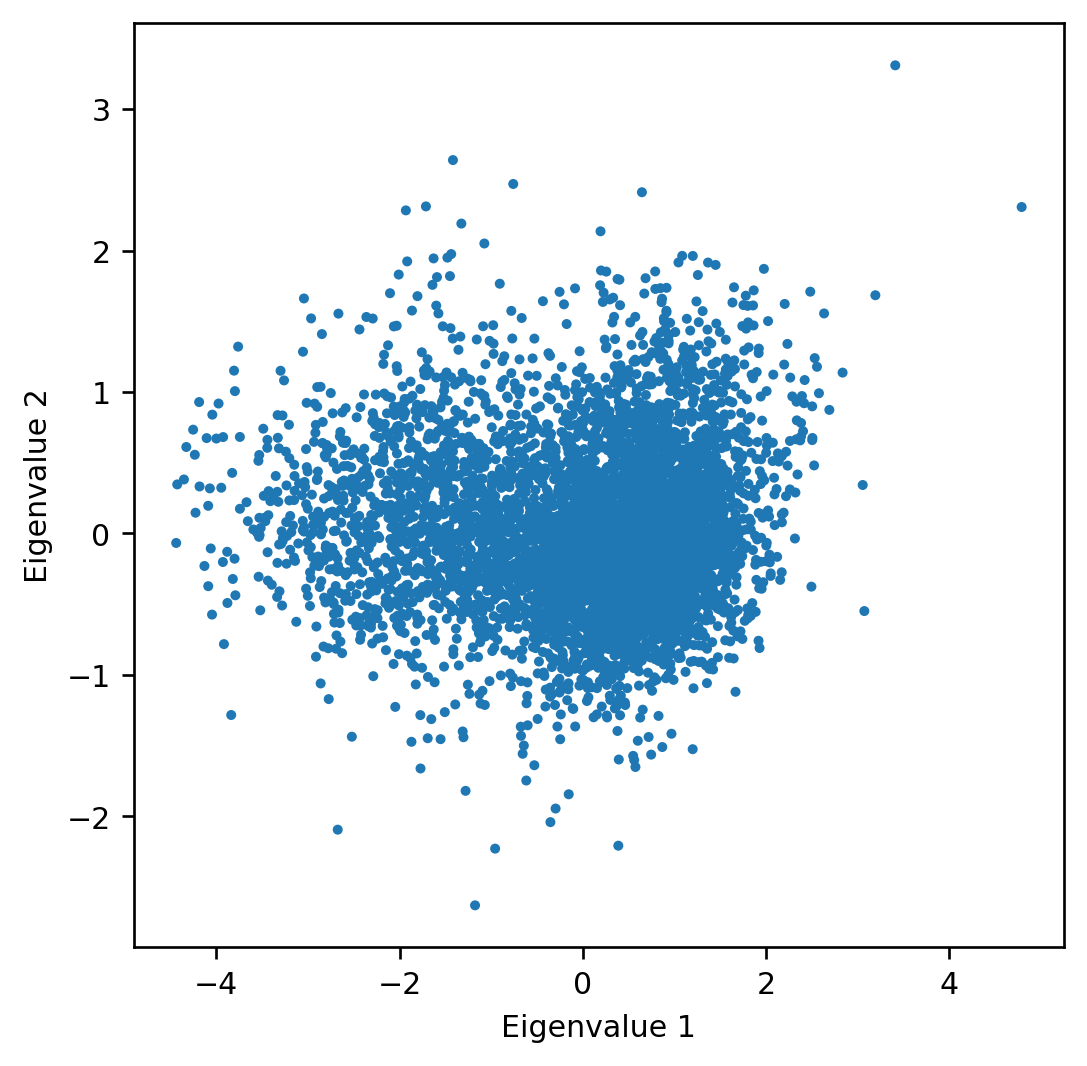

In [210]:
pca = PCA(n_components=2)
pca.fit(Xpca)

X_reduced = pca.transform(Xpca)

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot()
ax.scatter(X_reduced[:,0], X_reduced[:,1], 
            marker=".", color='C0', 
            alpha=1, edgecolors='None')
ax.set_xlabel('Eigenvector 1')
ax.set_ylabel('Eigenvector 2')

In [211]:
# KMeans
km2 = KMeans(n_clusters = 2)
km2.fit(X_reduced)
km2_centers_2d = km2.cluster_centers_ 
km2_labels_2d = km2.predict(X_reduced)
print(km2_centers_2d)

[[ 0.57392761 -0.03772984]
 [-1.71596601  0.11280713]]


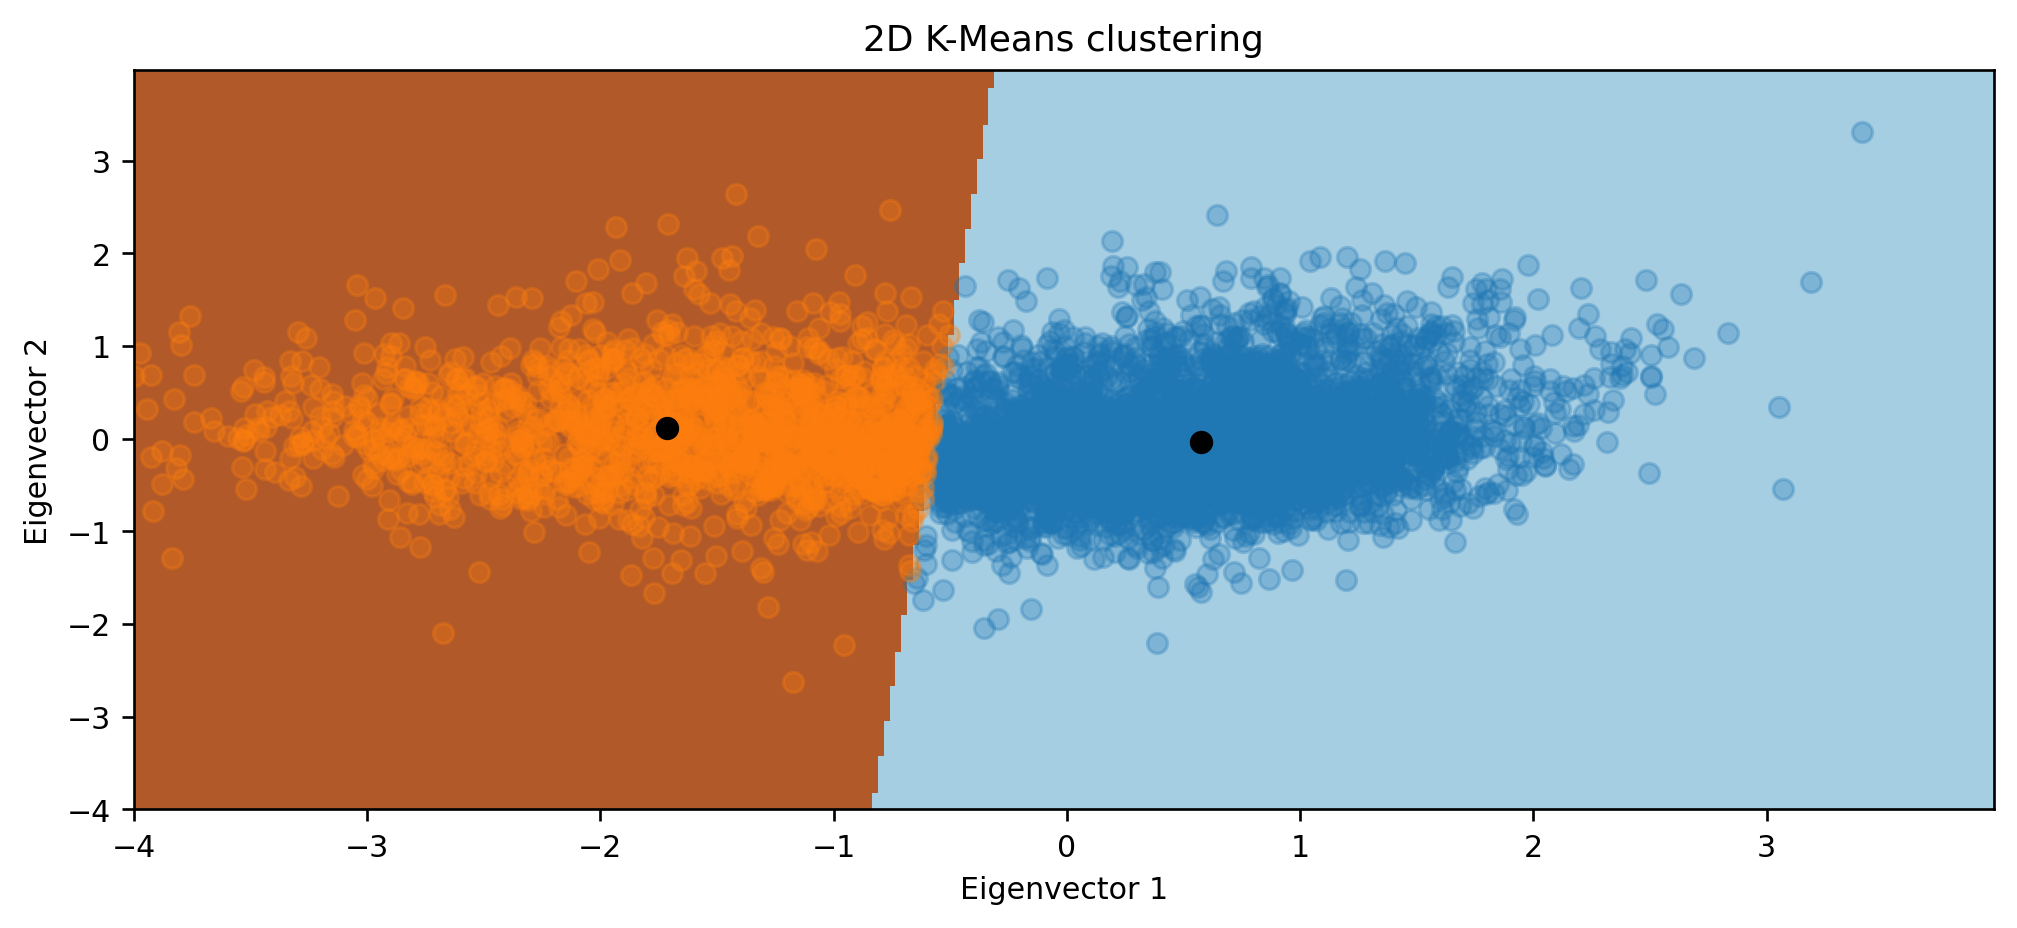

In [213]:
ax = plt.subplot(111)
for i in range(2):
    ax.scatter(X_reduced[km2_labels_2d == i, 0], X_reduced[km2_labels_2d == i, 1], alpha = 0.3)
ax.scatter(km2_centers_2d[:, 0], km2_centers_2d[:, 1], c='k')

ax.set_xlabel('Eigenvector 1')
ax.set_ylabel('Eigenvector 2')
ax.set_title('2D K-Means clustering')

# Decision boundaries
delta = 0.025
x = np.arange(-4.0, 4.0, delta)
y = np.arange(-4.0, 4.0, delta)
xx, yy = np.meshgrid(x, y)
XX = np.array([xx.ravel(), yy.ravel()]).T
Z = km2.predict(XX)
Z = Z.reshape(xx.shape)
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

In [216]:
# Re-do Kmeans on cleaned dataset for PCA

X_2d_clean = Xpca[:,(0,2)]

km = KMeans(n_clusters = 2)
km.fit(X_2d_clean)
km_centers_2d = km.cluster_centers_ 
km_labels_2d = km.predict(X_2d_clean)
print(km_centers_2d)

[[ 0.02343161 -6.74168439]
 [ 1.48747042 -5.420515  ]]


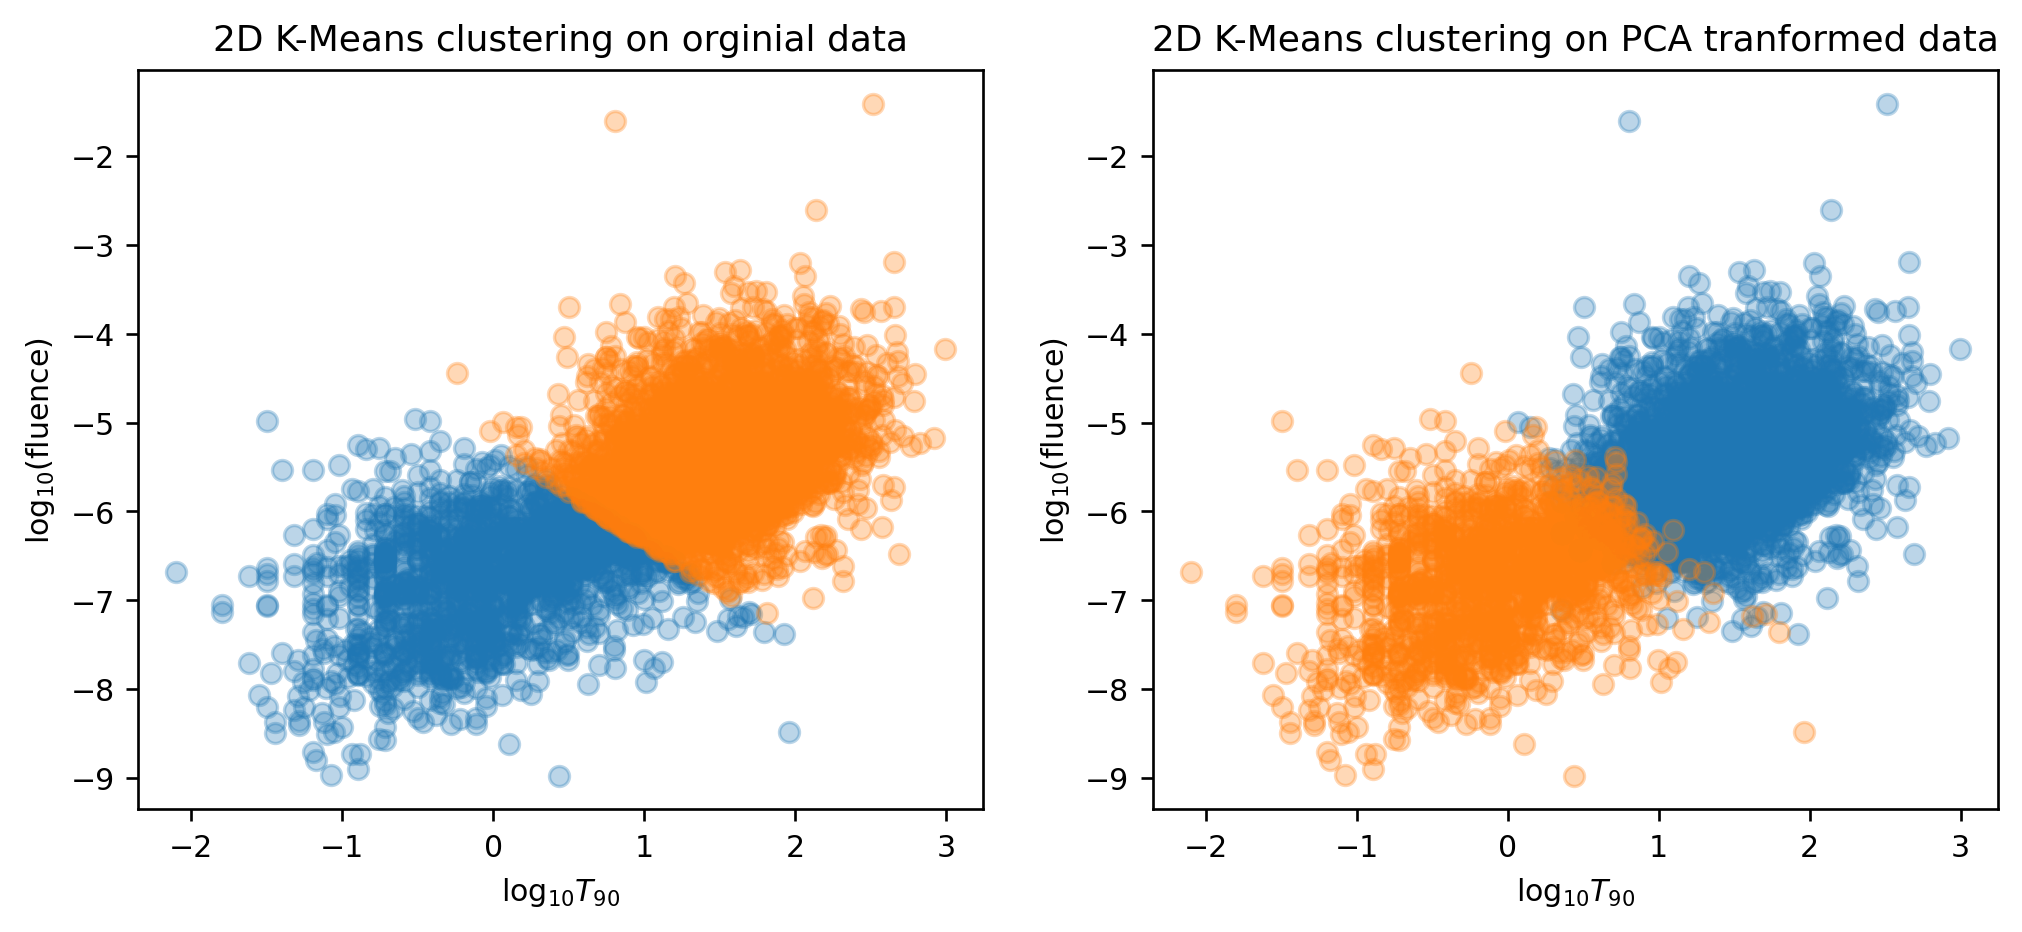

In [219]:
ax = plt.subplot(121)
for i in range(2):
    ax.scatter(X_2d_clean[km_labels_2d == i, 0], X_2d_clean[km_labels_2d == i, 1], alpha = 0.3)

ax.set_xlabel(r'$\log_{10}T_{90}$')
ax.set_ylabel(r'$\log_{10}$(fluence)')
ax.set_title('2D K-Means clustering on orginial data')

ax = plt.subplot(122)
for i in range(2):
    ax.scatter(X_2d_clean[km2_labels_2d == i, 0], X_2d_clean[km2_labels_2d == i, 1], alpha = 0.3)

ax.set_xlabel(r'$\log_{10}T_{90}$')
ax.set_ylabel(r'$\log_{10}$(fluence)')
ax.set_title('2D K-Means clustering on PCA tranformed data');

Not much of a change: probably because we already chose the most informative features